In [240]:
# Import libraries
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path
import re as re

# Imports to print out pretty pandas dataframes
from IPython.display import display, HTML

# Imports for accessing mimic data using Google BigQuery.
from google.cloud import bigquery

#Database name (for reference & use in queries): 
#physionet-data.mimiciii_clinical (must bracket with ` backwards quotes from ~ key, and surround whole query with ''''' 
#   if using in-line SQL not an SQL file)
#   eg: 
#   run_query('''
#   select subject_id from `physionet-data.mimiciii_clinical.admissions`
#   ''')

In [241]:
project='hst-953-2018'
os.environ["GOOGLE_CLOUD_PROJECT"]=project

In [242]:
def run_query(query):
  return pd.io.gbq.read_gbq(query, project_id=project, verbose=True, configuration={'query':{'useLegacySql': False}})


In [ ]:
#Select all potential patients from MIMIC - all patietns, with ICU stay numbered

#This query is time consuming. Recommend saving the oputut to file and referencing 
#that if running more analysis, and converting this cell to text of markdown. 
#Re-running this entire query will take a long time. 

AllAdmit = run_query('''
SELECT icu.subject_id, icu.hadm_id, icu.icustay_id, pat.gender,  
adm.hospital_expire_flag,
DATETIME_DIFF(adm.admittime, pat.dob, YEAR) AS ageatadmin,
DATETIME_DIFF(adm.dischtime, adm.admittime, DAY) AS hosp_LOS_d,
RANK() OVER (PARTITION BY icu.subject_id ORDER BY icu.intime) AS icustay_id_order, 
DATETIME_DIFF(icu.outtime, icu.intime, HOUR) AS icu_length_of_stay, adm.deathtime, adm.admission_type, 
adm.admission_location, adm.ethnicity, adm.diagnosis, serv.prev_service, serv.curr_service
FROM `physionet-data.mimiciii_clinical.icustays` icu
INNER JOIN `physionet-data.mimiciii_clinical.admissions` adm
ON icu.hadm_id = adm.hadm_id
INNER JOIN `physionet-data.mimiciii_clinical.patients`  pat
ON icu.subject_id = pat.subject_id
INNER JOIN `physionet-data.mimiciii_clinical.services`  serv
ON icu.hadm_id = serv.hadm_id''')

AllAdmit

In [243]:
#To generate datafile to avoid re-querying database each time 
#Rec: switch this to text cell when file already saved to avoid overwriting

AllAdmit.to_csv(index=False, path_or_buf='AllAdmit.csv')

In [244]:
#Read in the generated datafile, AllAdmit

AllAdmit = pd.read_csv('AllAdmit.csv')

AllAdmit

,subject_id,hadm_id,icustay_id,gender,hospital_expire_flag,ageatadmin,hosp_LOS_d,icustay_id_order,icu_length_of_stay,deathtime,admission_type,admission_location,ethnicity,diagnosis,prev_service,curr_service
0,2,163353,243653,M,0,0,4,1,2.0,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,ASIAN,NEWBORN,NaN,NB
1,3,145834,211552,M,0,76,11,1,145.0,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,WHITE,HYPOTENSION,NaN,VSURG
2,3,145834,211552,M,0,76,11,1,145.0,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,WHITE,HYPOTENSION,VSURG,MED
3,4,185777,294638,F,0,48,7,1,40.0,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",NaN,MED
4,5,178980,214757,M,0,0,2,1,2.0,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,ASIAN,NEWBORN,NaN,NB
5,6,107064,228232,F,0,66,16,1,88.0,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,WHITE,CHRONIC RENAL FAILURE/SDA,NaN,SURG
6,7,118037,278444,F,0,0,4,1,7.0,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,WHITE,NEWBORN,NaN,NB
7,7,118037,236754,F,0,0,4,2,18.0,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,WHITE,NEWBORN,NaN,NB
8,8,159514,262299,M,0,0,4,1,26.0,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,WHITE,NEWBORN,NaN,NB
9,9,150750,220597,M,1,41,5,1,127.0,2149-11-14 10:15:00,EMERGENCY,EMERGENCY ROOM ADMIT,UNKNOWN/NOT SPECIFIED,HEMORRHAGIC CVA,NaN,NMED


In [245]:
# Generate new df with the exclusions:
#  age >15 and <150
#  first ICU stay only
#  ICU stay >=4 hrs

AdmitFullCohort = AllAdmit[
    (AllAdmit.ageatadmin>=15) & (AllAdmit.ageatadmin<150)
    & (AllAdmit.icustay_id_order == 1)
    & (AllAdmit.icu_length_of_stay >= 4)
    ]

AdmitFullCohort

,subject_id,hadm_id,icustay_id,gender,hospital_expire_flag,ageatadmin,hosp_LOS_d,icustay_id_order,icu_length_of_stay,deathtime,admission_type,admission_location,ethnicity,diagnosis,prev_service,curr_service
1,3,145834,211552,M,0,76,11,1,145.0,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,WHITE,HYPOTENSION,NaN,VSURG
2,3,145834,211552,M,0,76,11,1,145.0,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,WHITE,HYPOTENSION,VSURG,MED
3,4,185777,294638,F,0,48,7,1,40.0,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",NaN,MED
5,6,107064,228232,F,0,66,16,1,88.0,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,WHITE,CHRONIC RENAL FAILURE/SDA,NaN,SURG
9,9,150750,220597,M,1,41,5,1,127.0,2149-11-14 10:15:00,EMERGENCY,EMERGENCY ROOM ADMIT,UNKNOWN/NOT SPECIFIED,HEMORRHAGIC CVA,NaN,NMED
11,11,194540,229441,F,0,50,25,1,38.0,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,WHITE,BRAIN MASS,NaN,NSURG
12,11,194540,229441,F,0,50,25,1,38.0,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,WHITE,BRAIN MASS,NSURG,NMED
13,12,112213,232669,M,1,72,13,1,183.0,2104-08-20 02:57:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,WHITE,PANCREATIC CANCER/SDA,NaN,SURG
14,13,143045,263738,F,0,40,7,1,88.0,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,WHITE,CORONARY ARTERY DISEASE,NaN,CMED
15,13,143045,263738,F,0,40,7,1,88.0,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,WHITE,CORONARY ARTERY DISEASE,CMED,CSURG


In [246]:
#patients may have more than one "current service" during same admission
# and this creates extra rows for the same ICU stay, when only thing 
# different is the service 
#  Need to concatanate them into a single row which lists the ervices

Srvc = AdmitFullCohort.groupby(['subject_id'])['curr_service'].apply(
    lambda x: ','.join(x.astype(str))).reset_index()

Srvc.columns=['subject_id','service']

Srvc.head()

,subject_id,service
0,3,"VSURG,MED"
1,4,MED
2,6,SURG
3,9,NMED
4,11,"NSURG,NMED"


In [247]:
#above creates 2-column dataframe, merge back with larger data frame, 
#replacing old curr_service column and dropping prev-service comletely

AdmitFullCohort=AdmitFullCohort.drop(['prev_service','curr_service'],axis=1)

AdmitFullCohort.head

<bound method NDFrame.head of        subject_id  hadm_id  icustay_id gender  hospital_expire_flag  \
1               3   145834      211552      M                     0   
2               3   145834      211552      M                     0   
3               4   185777      294638      F                     0   
5               6   107064      228232      F                     0   
9               9   150750      220597      M                     1   
11             11   194540      229441      F                     0   
12             11   194540      229441      F                     0   
13             12   112213      232669      M                     1   
14             13   143045      263738      F                     0   
15             13   143045      263738      F                     0   
17             17   194023      277042      F                     0   
19             18   188822      298129      M                     0   
21             20   157681      264490      F  

In [248]:
#df shape check after dropping duplicates (yields 36466 x 14)

AdmitFullCohort=AdmitFullCohort.drop_duplicates()

AdmitFullCohort.shape 

(36466, 14)

In [249]:
#Add back the new Srvc column

AdmitFullCohort = pd.merge(AdmitFullCohort,Srvc, on='subject_id',how='inner')
AdmitFullCohort.head(5)

,subject_id,hadm_id,icustay_id,gender,hospital_expire_flag,ageatadmin,hosp_LOS_d,icustay_id_order,icu_length_of_stay,deathtime,admission_type,admission_location,ethnicity,diagnosis,service
0,3,145834,211552,M,0,76,11,1,145.0,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,WHITE,HYPOTENSION,"VSURG,MED"
1,4,185777,294638,F,0,48,7,1,40.0,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",MED
2,6,107064,228232,F,0,66,16,1,88.0,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,WHITE,CHRONIC RENAL FAILURE/SDA,SURG
3,9,150750,220597,M,1,41,5,1,127.0,2149-11-14 10:15:00,EMERGENCY,EMERGENCY ROOM ADMIT,UNKNOWN/NOT SPECIFIED,HEMORRHAGIC CVA,NMED
4,11,194540,229441,F,0,50,25,1,38.0,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,WHITE,BRAIN MASS,"NSURG,NMED"


In [250]:
#check shape, now 36466 x 15

AdmitFullCohort.shape

(36466, 15)

In [251]:
#Create flgas for initial diagnoses that include "renal failure", sepsis (as "SEPS")
#  and Infection as "INFEC"

AdmitFullCohort.loc[:,"RenalFailure_dx"] = AdmitFullCohort.diagnosis.str.contains("RENAL FAILURE")

AdmitFullCohort.loc[:,"Sepsis_dx"] = AdmitFullCohort.diagnosis.str.contains("SEPS")

AdmitFullCohort.loc[:,"Infec_dx"] = AdmitFullCohort.diagnosis.str.contains("INFECT")
#AdmitFullCohort.RenalFailure_dx

#This generates a setting with copy warning only when more than one of the new columns are created.
#However, all the columns appear in the modified dataframe
#and this is using the documentation-recommended .loc format. 
#so... decision made to ignore setting with copy warning. 

In [252]:
#test ability to slice by new column values 

AdmitFullCohort_Sepsis = AdmitFullCohort[AdmitFullCohort.Sepsis_dx == True]
AdmitFullCohort_RF = AdmitFullCohort[AdmitFullCohort.RenalFailure_dx == True]
AdmitFullCohort_Infec = AdmitFullCohort[AdmitFullCohort.Infec_dx == True]

CohortSepsis
#CohortRF
#AdmitFullCohort_Infec.head()


In [253]:
#this is the resulting df of all adult fist-ICU-admissions, containing admission info
#  service, demographic info. Contains no lab or vitals, and not yet limited to those who 
#  HAVE and outpatient lab value within specified timeframe 

#Can take this cohort minus the cohort that DO hae labs to select the group that 
#  DOESN'T for comparison

AdmitFullCohort
#AdmitFullCohort['subject_id'].unique().size

#Now has 36,466 rows which are all unique patients 

,subject_id,hadm_id,icustay_id,gender,hospital_expire_flag,ageatadmin,hosp_LOS_d,icustay_id_order,icu_length_of_stay,deathtime,admission_type,admission_location,ethnicity,diagnosis,service,RenalFailure_dx,Sepsis_dx,Infec_dx
0,3,145834,211552,M,0,76,11,1,145.0,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,WHITE,HYPOTENSION,"VSURG,MED",False,False,False
1,4,185777,294638,F,0,48,7,1,40.0,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",MED,False,False,False
2,6,107064,228232,F,0,66,16,1,88.0,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,WHITE,CHRONIC RENAL FAILURE/SDA,SURG,True,False,False
3,9,150750,220597,M,1,41,5,1,127.0,2149-11-14 10:15:00,EMERGENCY,EMERGENCY ROOM ADMIT,UNKNOWN/NOT SPECIFIED,HEMORRHAGIC CVA,NMED,False,False,False
4,11,194540,229441,F,0,50,25,1,38.0,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,WHITE,BRAIN MASS,"NSURG,NMED",False,False,False
5,12,112213,232669,M,1,72,13,1,183.0,2104-08-20 02:57:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,WHITE,PANCREATIC CANCER/SDA,SURG,False,False,False
6,13,143045,263738,F,0,40,7,1,88.0,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,WHITE,CORONARY ARTERY DISEASE,"CMED,CSURG",False,False,False
7,17,194023,277042,F,0,47,4,1,50.0,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,WHITE,PATIENT FORAMEN OVALE\ PATENT FORAMEN OVALE MI...,CSURG,False,False,False
8,18,188822,298129,M,0,51,2,1,31.0,NaN,EMERGENCY,PHYS REFERRAL/NORMAL DELI,WHITE,HYPOGLYCEMIA;SEIZURES,MED,False,False,False
9,20,157681,264490,F,0,76,5,1,25.0,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,CSURG,False,False,False


In [254]:
#shape check: Now 36466 x 18 with the new columns 

AdmitFullCohort.shape


(36466, 18)

In [ ]:
# This query is also somewhat time consuoming. Recommend saving output to file, then
# switching cell to markdow to avoid re-running query 

# generates list of demographics and baseline cr values for any pt having Cr drawn 3-360 days before a hospital admission

#OVERVIEW 
#Select the outpatient creatinine values:
#Use the labs table from physionet. Pull the demographic markers, time the lab was done,
    #time of admission, value of and label (name) for the lab.
    #Merge this with the namelab table on the item ID -- which for Cr is 50912
    #Join this with the admissions table by matching with subject_id
    #Join this with the icustays table my matching on hadm_id
    #Call table generated from the above "Cr"
#Then from Cr, take the demographic markers, charttime for the lab, patient admittime,
    #creatinine value and label and the calculated labs_timelag variable (admittime-charttime)
    #and show this new table where the timelag is greater than 3 and less than 360 days
    #(note labs_timelag is negative, so "lower" numbers are longer ago)
    

CrOut1 = run_query('''WITH Cr AS
(SELECT labs.row_id, labs.subject_id,icu.icustay_id, labs.hadm_id, labs.charttime, adm.admittime, 
            labs.itemid, labs.valuenum, namelab.label,
            DATETIME_DIFF(labs.charttime, adm.admittime, DAY) AS labs_timelag
            FROM `physionet-data.mimiciii_clinical.labevents` labs
             INNER JOIN `physionet-data.mimiciii_clinical.d_labitems` namelab
              ON labs.itemid = namelab.itemid
            INNER JOIN `physionet-data.mimiciii_clinical.admissions` adm
            ON labs.subject_id = adm.subject_id
            INNER JOIN `physionet-data.mimiciii_clinical.icustays` icu
            ON adm.hadm_id = icu.hadm_id
            WHERE labs.itemid = 50912)
SELECT Cr.subject_id, Cr.icustay_id, Cr.hadm_id, Cr.charttime, Cr.admittime, Cr.itemid, 
            Cr.valuenum, Cr.label, Cr.labs_timelag FROM Cr 
            WHERE (Cr.labs_timelag > -360 AND  Cr.labs_timelag < -3)
  ''')

CrOut1
  
  
  
#this will need to be matched with the previously selected icustay_id's

In [255]:
#Save output of above query to file -- rec switch to cell to text once saved to avoid
#  overweriting 


CrOut1.to_csv(index=False, path_or_buf='CrOut.csv')

In [256]:
#Read in above generated datafile & show header

CrOut1 = pd.read_csv('CrOut.csv')
CrOut1.head()

,subject_id,icustay_id,hadm_id,charttime,admittime,itemid,valuenum,label,labs_timelag
0,109,257698,164029.0,2140-01-20 09:32:00,2140-02-02 02:13:00,50912,4.3,Creatinine,-13
1,109,243688,164029.0,2140-01-20 09:32:00,2140-04-07 19:51:00,50912,4.3,Creatinine,-78
2,109,231823,164029.0,2140-01-20 09:32:00,2140-05-17 14:27:00,50912,4.3,Creatinine,-118
3,109,221610,164029.0,2140-01-20 09:32:00,2140-08-25 14:39:00,50912,4.3,Creatinine,-218
4,384,221759,130196.0,2161-04-13 05:58:00,2161-06-29 22:30:00,50912,7.2,Creatinine,-77


In [257]:
CrOut1.shape

(295994, 9)

In [258]:
#limit to outpatient values - eg where hospital admission id's are nan
CrOut = CrOut1.loc[pd.isna(CrOut1['hadm_id'])] 

CrOut.head()

,subject_id,icustay_id,hadm_id,charttime,admittime,itemid,valuenum,label,labs_timelag
11,3866,280424,NaN,2133-04-23 07:45:00,2133-05-16 17:35:00,50912,8.1,Creatinine,-23
12,3839,243984,NaN,2116-02-12 08:35:00,2116-03-11 16:17:00,50912,0.1,Creatinine,-28
16,9363,247367,NaN,2154-10-28 07:00:00,2155-10-13 17:36:00,50912,8.7,Creatinine,-350
17,9363,276771,NaN,2154-10-28 07:00:00,2155-10-20 21:42:00,50912,8.7,Creatinine,-357
22,13033,218639,NaN,2187-08-25 15:00:00,2187-12-17 20:53:00,50912,10.4,Creatinine,-114


In [259]:
#Now we want to keep all the patients in AdmitFullCohort *except* those that appear in CrOut
# so we'll use ~ to negate isin

NonCrCohort = AdmitFullCohort[~AdmitFullCohort["icustay_id"].isin(CrOut["icustay_id"])]

NonCrCohort

,subject_id,hadm_id,icustay_id,gender,hospital_expire_flag,ageatadmin,hosp_LOS_d,icustay_id_order,icu_length_of_stay,deathtime,admission_type,admission_location,ethnicity,diagnosis,service,RenalFailure_dx,Sepsis_dx,Infec_dx
1,4,185777,294638,F,0,48,7,1,40.0,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",MED,False,False,False
3,9,150750,220597,M,1,41,5,1,127.0,2149-11-14 10:15:00,EMERGENCY,EMERGENCY ROOM ADMIT,UNKNOWN/NOT SPECIFIED,HEMORRHAGIC CVA,NMED,False,False,False
4,11,194540,229441,F,0,50,25,1,38.0,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,WHITE,BRAIN MASS,"NSURG,NMED",False,False,False
5,12,112213,232669,M,1,72,13,1,183.0,2104-08-20 02:57:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,WHITE,PANCREATIC CANCER/SDA,SURG,False,False,False
6,13,143045,263738,F,0,40,7,1,88.0,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,WHITE,CORONARY ARTERY DISEASE,"CMED,CSURG",False,False,False
8,18,188822,298129,M,0,51,2,1,31.0,NaN,EMERGENCY,PHYS REFERRAL/NORMAL DELI,WHITE,HYPOGLYCEMIA;SEIZURES,MED,False,False,False
11,22,165315,204798,F,0,65,1,1,27.0,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,WHITE,BENZODIAZEPINE OVERDOSE,MED,False,False,False
13,24,161859,262236,M,0,39,3,1,12.0,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,WHITE,INTERIOR MYOCARDIAL INFARCTION,CMED,False,False,False
14,25,129635,203487,M,0,59,3,1,85.0,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,WHITE,ACUTE CORONARY SYNDROME,CMED,False,False,False
15,26,197661,244882,M,0,72,7,1,52.0,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,UNKNOWN/NOT SPECIFIED,V-TACH,CMED,False,False,False


In [260]:
#Save to file if desired

NonCrCohort.to_csv(index=False, path_or_buf='CrOut.csv')

In [261]:
NonCrCohort['subject_id'].unique().size

#Size check: yields 30,035 unique pts (adult 1st ICU admissions that 
#  DO NOT have outpt Cr within 1 yr)

30035

In [ ]:
# select all Cr values (id 50912) drawn within 24 hrs of *any* ICU admission for *any* pt

#Can change to text to avoid re-running query each time whne file saved

Cr_initial_all_1 = run_query('''WITH Cr AS
(SELECT labs.row_id, labs.subject_id,icu.icustay_id, icu.intime, labs.hadm_id, labs.charttime, 
            adm.admittime, labs.itemid, labs.valuenum, namelab.label,
            DATETIME_DIFF(labs.charttime ,adm.admittime, MINUTE) AS labs_minutelag,
            DATETIME_DIFF(labs.charttime ,icu.intime, MINUTE) AS labs_icuminutelag
            FROM `physionet-data.mimiciii_clinical.labevents` labs
             INNER JOIN `physionet-data.mimiciii_clinical.d_labitems` namelab
              ON labs.itemid = namelab.itemid
            INNER JOIN `physionet-data.mimiciii_clinical.admissions` adm
            ON labs.subject_id = adm.subject_id
            INNER JOIN `physionet-data.mimiciii_clinical.icustays` icu
            ON adm.hadm_id = icu.hadm_id
            WHERE labs.itemid = 50912)
SELECT Cr.subject_id, Cr.icustay_id, Cr.hadm_id, Cr.charttime, Cr.admittime, Cr.itemid, 
            Cr.valuenum, Cr.label, Cr.intime, Cr.labs_icuminutelag, Cr.labs_minutelag FROM Cr
  WHERE (Cr.labs_minutelag >= -1440 AND Cr.labs_icuminutelag <= 1440 )
  ''')


In [262]:
#Generate datafile to avoid re-querying database each time 
#Switch cell to text to avoid overwriting once saved 

Cr_initial_all_1.to_csv(index=False, path_or_buf='Cr_initial_all_1.csv')


In [263]:
#Read in generated datafile

Cr_initial_all_1 = pd.read_csv('Cr_initial_all_1.csv')

Cr_initial_all_1.head()

,subject_id,icustay_id,hadm_id,charttime,admittime,itemid,valuenum,label,intime,labs_icuminutelag,labs_minutelag
0,1351,206576,NaN,2188-05-02 20:18:00,2188-05-03 12:39:00,50912,5.2,Creatinine,2188-05-03 12:40:54,-982,-981
1,2195,260197,133914.0,2158-01-04 06:00:00,2157-12-29 23:01:00,50912,3.2,Creatinine,2158-01-05 14:50:24,-1970,7619
2,3267,292437,134934.0,2191-12-02 10:08:00,2191-11-04 18:05:00,50912,4.4,Creatinine,2191-12-09 20:18:36,-10690,39843
3,4012,274134,139326.0,2131-02-27 22:33:00,2131-02-24 15:12:00,50912,8.5,Creatinine,2131-03-07 16:35:48,-11162,4761
4,4004,209029,184838.0,2171-08-11 04:00:00,2171-07-29 00:27:00,50912,3.1,Creatinine,2171-08-13 22:07:03,-3967,18933


In [264]:
#Remove rows wehere hadm_id is NaN, we need to convert hadm_id column to integer to facilitate
# later merge (for some reason the earlier queries have it as integer not float)

Cr_initial_all2 = Cr_initial_all_1.loc[pd.notna(Cr_initial_all_1['hadm_id'])] 
Cr_initial_all2.columns

Index(['subject_id', 'icustay_id', 'hadm_id', 'charttime', 'admittime',
       'itemid', 'valuenum', 'label', 'intime', 'labs_icuminutelag',
       'labs_minutelag'],
      dtype='object')

In [265]:
Cr_initial_all=Cr_initial_all2
Cr_initial_all.loc[:,'hadm_id']=Cr_initial_all2['hadm_id'].astype(int)

Cr_initial_all.rename(columns={'charttime':'Cr_initial_time', 'itemid':'Cr_itemid',
                              'label':'LabName','valuenum':'Cr_value_initial',
                              'intime':'icu_intime'},inplace=True)

Cr_initial_all
#this still gives setting with copy warning. I am using two different df names to try to 
# be sure it won't cause a problem. 

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,subject_id,icustay_id,hadm_id,Cr_initial_time,admittime,Cr_itemid,Cr_value_initial,LabName,icu_intime,labs_icuminutelag,labs_minutelag
1,2195,260197,133914,2158-01-04 06:00:00,2157-12-29 23:01:00,50912,3.2,Creatinine,2158-01-05 14:50:24,-1970,7619
2,3267,292437,134934,2191-12-02 10:08:00,2191-11-04 18:05:00,50912,4.4,Creatinine,2191-12-09 20:18:36,-10690,39843
3,4012,274134,139326,2131-02-27 22:33:00,2131-02-24 15:12:00,50912,8.5,Creatinine,2131-03-07 16:35:48,-11162,4761
4,4004,209029,184838,2171-08-11 04:00:00,2171-07-29 00:27:00,50912,3.1,Creatinine,2171-08-13 22:07:03,-3967,18933
5,3914,228487,162645,2200-01-25 05:04:00,2200-01-20 14:00:00,50912,3.2,Creatinine,2200-01-24 13:41:32,923,6664
6,5247,285984,155530,2152-02-02 02:04:00,2152-02-01 11:47:00,50912,3.1,Creatinine,2152-02-01 11:49:08,855,857
7,6024,201296,106374,2127-09-25 07:30:00,2127-09-25 13:32:00,50912,3.9,Creatinine,2127-09-25 13:33:29,-363,-362
8,6440,276746,142164,2156-05-31 19:30:00,2156-05-31 23:51:00,50912,9.5,Creatinine,2156-05-31 23:53:29,-263,-261
9,6893,271980,145334,2187-05-18 07:41:00,2187-05-18 04:37:00,50912,12.8,Creatinine,2187-05-18 04:38:33,183,184
10,9248,291797,193330,2173-06-19 14:27:00,2173-06-18 15:09:00,50912,4.4,Creatinine,2173-06-18 15:11:30,1396,1398


In [266]:
#Column check 

Cr_initial_all.columns

Index(['subject_id', 'icustay_id', 'hadm_id', 'Cr_initial_time', 'admittime',
       'Cr_itemid', 'Cr_value_initial', 'LabName', 'icu_intime',
       'labs_icuminutelag', 'labs_minutelag'],
      dtype='object')

In [267]:
#Select the Cr_value that is closes to the ICU admission time -  eg has the lowest absolute
# value for labs_icuminutelag time) for each unique subject_id
 # This includes labs prior to ICU admission (ie time window symmetric about ICU admit time) 

#first create a new column of abdolute values, but don't eliminate normal labd_icuminutelag column

Cr_initial_all.loc[:,'abso_icuminutelag'] = Cr_initial_all['labs_icuminutelag'].abs()

Cr_initial_all

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,subject_id,icustay_id,hadm_id,Cr_initial_time,admittime,Cr_itemid,Cr_value_initial,LabName,icu_intime,labs_icuminutelag,labs_minutelag,abso_icuminutelag
1,2195,260197,133914,2158-01-04 06:00:00,2157-12-29 23:01:00,50912,3.2,Creatinine,2158-01-05 14:50:24,-1970,7619,1970
2,3267,292437,134934,2191-12-02 10:08:00,2191-11-04 18:05:00,50912,4.4,Creatinine,2191-12-09 20:18:36,-10690,39843,10690
3,4012,274134,139326,2131-02-27 22:33:00,2131-02-24 15:12:00,50912,8.5,Creatinine,2131-03-07 16:35:48,-11162,4761,11162
4,4004,209029,184838,2171-08-11 04:00:00,2171-07-29 00:27:00,50912,3.1,Creatinine,2171-08-13 22:07:03,-3967,18933,3967
5,3914,228487,162645,2200-01-25 05:04:00,2200-01-20 14:00:00,50912,3.2,Creatinine,2200-01-24 13:41:32,923,6664,923
6,5247,285984,155530,2152-02-02 02:04:00,2152-02-01 11:47:00,50912,3.1,Creatinine,2152-02-01 11:49:08,855,857,855
7,6024,201296,106374,2127-09-25 07:30:00,2127-09-25 13:32:00,50912,3.9,Creatinine,2127-09-25 13:33:29,-363,-362,363
8,6440,276746,142164,2156-05-31 19:30:00,2156-05-31 23:51:00,50912,9.5,Creatinine,2156-05-31 23:53:29,-263,-261,263
9,6893,271980,145334,2187-05-18 07:41:00,2187-05-18 04:37:00,50912,12.8,Creatinine,2187-05-18 04:38:33,183,184,183
10,9248,291797,193330,2173-06-19 14:27:00,2173-06-18 15:09:00,50912,4.4,Creatinine,2173-06-18 15:11:30,1396,1398,1396


In [268]:
#next find Cr with minimum timelag from icu admission for each pt

Cr_init_first = Cr_initial_all.loc[Cr_initial_all.groupby(['subject_id',
                                                        'icustay_id'
                                                        ])['abso_icuminutelag'].idxmin()]                              

#Then create sub-cohorts based on who has labs within 2, 3, 6 and 24 hours of admission
Cr_initial24h=Cr_init_first[Cr_init_first['abso_icuminutelag']<=1440]
Cr_initial6h = Cr_init_first[Cr_init_first['abso_icuminutelag']<=360]
Cr_initial4h = Cr_init_first[Cr_init_first['abso_icuminutelag']<=240]
Cr_initial2h = Cr_init_first[Cr_init_first['abso_icuminutelag']<=120]
                                   
Cr_initial24h.shape


(53067, 12)

In [269]:
Cr_init_first

,subject_id,icustay_id,hadm_id,Cr_initial_time,admittime,Cr_itemid,Cr_value_initial,LabName,icu_intime,labs_icuminutelag,labs_minutelag,abso_icuminutelag
79164,3,211552,145834,2101-10-20 19:26:00,2101-10-20 19:08:00,50912,2.4,Creatinine,2101-10-20 19:10:11,16,18,16
37850,4,294638,185777,2191-03-16 05:42:00,2191-03-16 00:28:00,50912,0.5,Creatinine,2191-03-16 00:29:31,313,314,313
25248,6,228232,107064,2175-05-31 01:48:00,2175-05-30 07:15:00,50912,10.0,Creatinine,2175-05-30 21:30:54,258,1113,258
112694,9,220597,150750,2149-11-09 11:20:00,2149-11-09 13:06:00,50912,1.2,Creatinine,2149-11-09 13:07:02,-107,-106,107
148790,11,229441,194540,2178-04-16 07:12:00,2178-04-16 06:18:00,50912,0.7,Creatinine,2178-04-16 06:19:32,53,54,53
250920,12,232669,112213,2104-08-08 04:15:00,2104-08-07 10:15:00,50912,1.3,Creatinine,2104-08-08 02:08:17,127,1080,127
97548,13,263738,143045,2167-01-08 20:28:00,2167-01-08 18:43:00,50912,0.6,Creatinine,2167-01-08 18:44:25,104,105,104
130202,17,257980,161087,2135-05-09 15:13:00,2135-05-09 14:11:00,50912,0.7,Creatinine,2135-05-09 14:12:06,61,62,61
175224,17,277042,194023,2134-12-27 19:21:00,2134-12-27 07:15:00,50912,0.8,Creatinine,2134-12-27 16:21:48,180,726,180
241612,18,298129,188822,2167-10-02 10:36:00,2167-10-02 11:18:00,50912,0.9,Creatinine,2167-10-02 11:20:39,-44,-42,44


In [270]:
Cr_initial4h.columns

Index(['subject_id', 'icustay_id', 'hadm_id', 'Cr_initial_time', 'admittime',
       'Cr_itemid', 'Cr_value_initial', 'LabName', 'icu_intime',
       'labs_icuminutelag', 'labs_minutelag', 'abso_icuminutelag'],
      dtype='object')

In [271]:
#Start building the masterfiles for each time frame

Masterfile24h_NonCr = pd.merge(Cr_initial24h, NonCrCohort, 
                         on=['subject_id','icustay_id','hadm_id'], how='inner')

Masterfile6h_NonCr = pd.merge(Cr_initial6h, NonCrCohort, 
                         on=['subject_id','icustay_id','hadm_id'], how='inner')

Masterfile4h_NonCr = pd.merge(Cr_initial4h, NonCrCohort, 
                         on=['subject_id','icustay_id','hadm_id'], how='inner')

Masterfile2h_NonCr = pd.merge(Cr_initial2h, NonCrCohort, 
                         on=['subject_id','icustay_id','hadm_id'], how='inner')

Masterfile24h_NonCr

,subject_id,icustay_id,hadm_id,Cr_initial_time,admittime,Cr_itemid,Cr_value_initial,LabName,icu_intime,labs_icuminutelag,...,icu_length_of_stay,deathtime,admission_type,admission_location,ethnicity,diagnosis,service,RenalFailure_dx,Sepsis_dx,Infec_dx
0,4,294638,185777,2191-03-16 05:42:00,2191-03-16 00:28:00,50912,0.5,Creatinine,2191-03-16 00:29:31,313,...,40.0,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",MED,False,False,False
1,9,220597,150750,2149-11-09 11:20:00,2149-11-09 13:06:00,50912,1.2,Creatinine,2149-11-09 13:07:02,-107,...,127.0,2149-11-14 10:15:00,EMERGENCY,EMERGENCY ROOM ADMIT,UNKNOWN/NOT SPECIFIED,HEMORRHAGIC CVA,NMED,False,False,False
2,11,229441,194540,2178-04-16 07:12:00,2178-04-16 06:18:00,50912,0.7,Creatinine,2178-04-16 06:19:32,53,...,38.0,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,WHITE,BRAIN MASS,"NSURG,NMED",False,False,False
3,12,232669,112213,2104-08-08 04:15:00,2104-08-07 10:15:00,50912,1.3,Creatinine,2104-08-08 02:08:17,127,...,183.0,2104-08-20 02:57:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,WHITE,PANCREATIC CANCER/SDA,SURG,False,False,False
4,13,263738,143045,2167-01-08 20:28:00,2167-01-08 18:43:00,50912,0.6,Creatinine,2167-01-08 18:44:25,104,...,88.0,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,WHITE,CORONARY ARTERY DISEASE,"CMED,CSURG",False,False,False
5,18,298129,188822,2167-10-02 10:36:00,2167-10-02 11:18:00,50912,0.9,Creatinine,2167-10-02 11:20:39,-44,...,31.0,NaN,EMERGENCY,PHYS REFERRAL/NORMAL DELI,WHITE,HYPOGLYCEMIA;SEIZURES,MED,False,False,False
6,22,204798,165315,2196-04-09 10:14:00,2196-04-09 12:26:00,50912,0.6,Creatinine,2196-04-09 12:27:00,-133,...,27.0,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,WHITE,BENZODIAZEPINE OVERDOSE,MED,False,False,False
7,24,262236,161859,2139-06-06 17:54:00,2139-06-06 16:14:00,50912,0.9,Creatinine,2139-06-06 16:15:36,99,...,12.0,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,WHITE,INTERIOR MYOCARDIAL INFARCTION,CMED,False,False,False
8,25,203487,129635,2160-11-02 03:59:00,2160-11-02 02:06:00,50912,1.6,Creatinine,2160-11-02 03:16:23,43,...,85.0,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,WHITE,ACUTE CORONARY SYNDROME,CMED,False,False,False
9,26,244882,197661,2126-05-07 05:40:00,2126-05-06 15:16:00,50912,1.2,Creatinine,2126-05-07 09:52:30,-252,...,52.0,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,UNKNOWN/NOT SPECIFIED,V-TACH,CMED,False,False,False


In [272]:
Masterfile6h_NonCr.columns
Masterfile6h_NonCr.shape

(26535, 27)

In [273]:
Masterfile6h_NonCr['subject_id'].unique().size
#26535 rows, all unique pts

26535

In [ ]:
#switched to markdown to avoid re-running query each time 

all_labs = run_query ('''WITH all_labs AS
(SELECT labs.subject_id,icu.icustay_id, icu.intime, labs.hadm_id, labs.charttime, 
            adm.admittime, labs.itemid, labs.valuenum, namelab.label,
            DATETIME_DIFF(labs.charttime ,adm.admittime, MINUTE) AS labs_minutelag, 
            DATETIME_DIFF(labs.charttime ,icu.intime, MINUTE) AS labs_icuminutelag
            FROM `physionet-data.mimiciii_clinical.labevents` labs
             INNER JOIN `physionet-data.mimiciii_clinical.d_labitems` namelab
              ON labs.itemid = namelab.itemid
            INNER JOIN `physionet-data.mimiciii_clinical.admissions` adm
            ON labs.subject_id = adm.subject_id
            INNER JOIN `physionet-data.mimiciii_clinical.icustays` icu
            ON adm.hadm_id = icu.hadm_id
            WHERE labs.itemid in (50811, 50855, 51222, 51221, 50810, 51300, 51301, 51265, 50862, 50885, 50882, 50803, 50893, 
                      50902,50960, 50924,50925, 51237, 50952, 50953, 50813, 50954, 51250, 51248, 51249, 50818, 50820,
                      50970, 50821, 50971, 50976, 51274, 51275, 51279, 51006, 50983, 50998, 51010))
SELECT all_labs.subject_id, all_labs.icustay_id, all_labs.hadm_id, all_labs.charttime, all_labs.admittime,
            all_labs.itemid, all_labs.valuenum, all_labs.label, all_labs.labs_minutelag, all_labs.labs_icuminutelag
            FROM all_labs
            WHERE (all_labs.labs_minutelag >= -1440 AND  all_labs.labs_icuminutelag <= 1440)
  ''')


all_labs

In [276]:
#Save file. Comment out once saved to avoid overwriting

all_labs.to_csv(index=False, path_or_buf='all_labs.csv')

In [277]:
#read in above generated datafile
all_labs = pd.read_csv('all_labs.csv')
all_labs.head()

,subject_id,icustay_id,hadm_id,charttime,admittime,itemid,valuenum,label,labs_minutelag,labs_icuminutelag
0,100,221100,153952.0,2157-08-10 12:41:00,2157-08-10 07:15:00,50811,8.1,Hemoglobin,326,25
1,145,299479,138459.0,2145-02-15 17:15:00,2145-02-15 17:19:00,50954,161.0,Lactate Dehydrogenase (LD),-4,-5
2,335,278926,110777.0,2195-03-18 13:37:00,2195-03-18 11:15:00,50811,11.1,Hemoglobin,142,-8749
3,388,241204,167504.0,2104-04-15 10:27:00,2104-04-14 17:55:00,50811,10.3,Hemoglobin,992,184
4,433,208623,120589.0,2162-02-01 04:57:00,2162-01-18 11:32:00,50954,278.0,Lactate Dehydrogenase (LD),19765,662


In [278]:
all_labs_cohort = all_labs[all_labs['icustay_id'].isin(NonCrCohort['icustay_id'])]

all_labs_cohort

,subject_id,icustay_id,hadm_id,charttime,admittime,itemid,valuenum,label,labs_minutelag,labs_icuminutelag
4,433,208623,120589.0,2162-02-01 04:57:00,2162-01-18 11:32:00,50954,278.0,Lactate Dehydrogenase (LD),19765,662
7,1516,253422,110875.0,2112-01-06 14:37:00,2112-01-06 13:55:00,50954,204.0,Lactate Dehydrogenase (LD),42,-100
9,1557,234920,191920.0,2115-11-26 12:03:00,2115-11-26 13:43:00,50810,36.0,"Hematocrit, Calculated",-100,-359
10,1547,248466,153477.0,2135-12-20 18:28:00,2135-12-20 22:02:00,50953,127.0,"Iron Binding Capacity, Total",-214,-215
11,1985,229821,138520.0,2101-05-08 05:10:00,2101-05-07 18:05:00,50925,12.8,Folate,665,-4517
13,1928,218340,146368.0,2169-05-20 13:10:00,2169-05-20 16:22:00,50924,279.0,Ferritin,-192,-193
15,2356,203778,176708.0,2163-06-14 21:07:00,2163-06-14 17:42:00,50811,8.8,Hemoglobin,205,204
18,2649,271014,197327.0,2123-02-24 18:54:00,2123-02-24 22:17:00,50810,48.0,"Hematocrit, Calculated",-203,-205
21,3824,211828,124830.0,2162-11-28 05:30:00,2162-11-28 02:59:00,50954,5082.0,Lactate Dehydrogenase (LD),151,149
31,6497,244321,146241.0,2151-01-07 22:04:00,2151-01-07 22:34:00,50811,6.4,Hemoglobin,-30,-31


In [279]:
all_labs_cohort.shape

(2474854, 10)

In [280]:
all_labs_cohort['subject_id'].unique().size

#about right number of pts, lost a few possibly to not having labs near time of icu admission

29705

In [281]:
#consolidate long lab name labels 

all_labs_cohort.replace(['Calculated Bicarbonate, Whole Blood', 'WBC count',
                        'Hematocrit, Calculated'],
                        ['Bicarbonate','White Blood Cells', 'Hematocrit'],
                       inplace=True)



/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3795: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


In [282]:
#also add the absoulte value of the labs_icuminutelag column
all_labs_cohort.loc[:,'abso_icuminutelag'] = all_labs_cohort['labs_icuminutelag'].abs()

all_labs_cohort

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,subject_id,icustay_id,hadm_id,charttime,admittime,itemid,valuenum,label,labs_minutelag,labs_icuminutelag,abso_icuminutelag
4,433,208623,120589.0,2162-02-01 04:57:00,2162-01-18 11:32:00,50954,278.0,Lactate Dehydrogenase (LD),19765,662,662
7,1516,253422,110875.0,2112-01-06 14:37:00,2112-01-06 13:55:00,50954,204.0,Lactate Dehydrogenase (LD),42,-100,100
9,1557,234920,191920.0,2115-11-26 12:03:00,2115-11-26 13:43:00,50810,36.0,Hematocrit,-100,-359,359
10,1547,248466,153477.0,2135-12-20 18:28:00,2135-12-20 22:02:00,50953,127.0,"Iron Binding Capacity, Total",-214,-215,215
11,1985,229821,138520.0,2101-05-08 05:10:00,2101-05-07 18:05:00,50925,12.8,Folate,665,-4517,4517
13,1928,218340,146368.0,2169-05-20 13:10:00,2169-05-20 16:22:00,50924,279.0,Ferritin,-192,-193,193
15,2356,203778,176708.0,2163-06-14 21:07:00,2163-06-14 17:42:00,50811,8.8,Hemoglobin,205,204,204
18,2649,271014,197327.0,2123-02-24 18:54:00,2123-02-24 22:17:00,50810,48.0,Hematocrit,-203,-205,205
21,3824,211828,124830.0,2162-11-28 05:30:00,2162-11-28 02:59:00,50954,5082.0,Lactate Dehydrogenase (LD),151,149,149
31,6497,244321,146241.0,2151-01-07 22:04:00,2151-01-07 22:34:00,50811,6.4,Hemoglobin,-30,-31,31


In [283]:
#Remove the lab draws where the resultis listed as 0

all_labs_cohort = all_labs_cohort[all_labs_cohort['valuenum']!=0]

all_labs_cohort

,subject_id,icustay_id,hadm_id,charttime,admittime,itemid,valuenum,label,labs_minutelag,labs_icuminutelag,abso_icuminutelag
4,433,208623,120589.0,2162-02-01 04:57:00,2162-01-18 11:32:00,50954,278.0,Lactate Dehydrogenase (LD),19765,662,662
7,1516,253422,110875.0,2112-01-06 14:37:00,2112-01-06 13:55:00,50954,204.0,Lactate Dehydrogenase (LD),42,-100,100
9,1557,234920,191920.0,2115-11-26 12:03:00,2115-11-26 13:43:00,50810,36.0,Hematocrit,-100,-359,359
10,1547,248466,153477.0,2135-12-20 18:28:00,2135-12-20 22:02:00,50953,127.0,"Iron Binding Capacity, Total",-214,-215,215
11,1985,229821,138520.0,2101-05-08 05:10:00,2101-05-07 18:05:00,50925,12.8,Folate,665,-4517,4517
13,1928,218340,146368.0,2169-05-20 13:10:00,2169-05-20 16:22:00,50924,279.0,Ferritin,-192,-193,193
15,2356,203778,176708.0,2163-06-14 21:07:00,2163-06-14 17:42:00,50811,8.8,Hemoglobin,205,204,204
18,2649,271014,197327.0,2123-02-24 18:54:00,2123-02-24 22:17:00,50810,48.0,Hematocrit,-203,-205,205
21,3824,211828,124830.0,2162-11-28 05:30:00,2162-11-28 02:59:00,50954,5082.0,Lactate Dehydrogenase (LD),151,149,149
31,6497,244321,146241.0,2151-01-07 22:04:00,2151-01-07 22:34:00,50811,6.4,Hemoglobin,-30,-31,31


In [284]:
#How many labs have NaN value? (answer: 2399)
all_labs_cohort[pd.isna(all_labs_cohort['valuenum'])].shape 


(2399, 11)

In [285]:
# drop the NaNs
all_labs_cohort.dropna(subset=['valuenum'], inplace=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [286]:
#filter the labs by absolute value of timelag to be within different windows of ICU admission
# then find value closed to icu admission using groupby
# then use pivot table to take separate row values and put them into columns
# then combine with previous masterfile which has demographics and the admission/baseline Cr
# Repeat for each time frame of interest (24, 6, 4, and 2 hrs)

aLabs_24h = all_labs_cohort[all_labs_cohort.abso_icuminutelag <1440]  

bLabs_24h = aLabs_24h.loc[aLabs_24h.groupby(['icustay_id','label','itemid'])
                       ['abso_icuminutelag'].idxmin()]

Labs_24h = pd.pivot_table(bLabs_24h, index='icustay_id', columns = 'label', values = 'valuenum')

Masterfile24h_NonCr = pd.merge(Masterfile24h_NonCr, Labs_24h, on=['icustay_id'], how ='inner')
Masterfile24h_NonCr.head()


,subject_id,icustay_id,hadm_id,Cr_initial_time,admittime,Cr_itemid,Cr_value_initial,LabName,icu_intime,labs_icuminutelag,...,Red Blood Cells,Sodium,Transferrin,Urea Nitrogen,Vitamin B12,WBC Count,White Blood Cells,pCO2,pH,pO2
0,4,294638,185777,2191-03-16 05:42:00,2191-03-16 00:28:00,50912,0.5,Creatinine,2191-03-16 00:29:31,313,...,3.42,141.0,NaN,10.0,NaN,NaN,9.7,28.0,7.47,74.0
1,9,220597,150750,2149-11-09 11:20:00,2149-11-09 13:06:00,50912,1.2,Creatinine,2149-11-09 13:07:02,-107,...,5.46,140.0,NaN,16.0,NaN,NaN,7.5,46.0,7.39,75.0
2,11,229441,194540,2178-04-16 07:12:00,2178-04-16 06:18:00,50912,0.7,Creatinine,2178-04-16 06:19:32,53,...,4.45,141.0,NaN,14.0,NaN,NaN,9.3,NaN,NaN,NaN
3,12,232669,112213,2104-08-08 04:15:00,2104-08-07 10:15:00,50912,1.3,Creatinine,2104-08-08 02:08:17,127,...,4.40,145.0,NaN,28.0,NaN,NaN,8.4,36.0,7.02,276.0
4,13,263738,143045,2167-01-08 20:28:00,2167-01-08 18:43:00,50912,0.6,Creatinine,2167-01-08 18:44:25,104,...,4.08,139.0,NaN,13.0,NaN,NaN,16.6,43.0,7.38,369.0


In [287]:
aLabs_6h = all_labs_cohort[all_labs_cohort.abso_icuminutelag <360]  

bLabs_6h = aLabs_6h.loc[aLabs_6h.groupby(['icustay_id','label','itemid'])
                       ['abso_icuminutelag'].idxmin()]

Labs_6h = pd.pivot_table(bLabs_6h, index='icustay_id', columns = 'label', values = 'valuenum')

Masterfile6h_NonCr = pd.merge(Masterfile6h_NonCr, Labs_6h, on=['icustay_id'], how ='inner')
Masterfile6h_NonCr.head()

,subject_id,icustay_id,hadm_id,Cr_initial_time,admittime,Cr_itemid,Cr_value_initial,LabName,icu_intime,labs_icuminutelag,...,Red Blood Cells,Sodium,Transferrin,Urea Nitrogen,Vitamin B12,WBC Count,White Blood Cells,pCO2,pH,pO2
0,4,294638,185777,2191-03-16 05:42:00,2191-03-16 00:28:00,50912,0.5,Creatinine,2191-03-16 00:29:31,313,...,3.42,141.0,NaN,10.0,NaN,NaN,9.7,28.0,7.47,74.0
1,9,220597,150750,2149-11-09 11:20:00,2149-11-09 13:06:00,50912,1.2,Creatinine,2149-11-09 13:07:02,-107,...,5.46,140.0,NaN,16.0,NaN,NaN,7.5,46.0,7.39,75.0
2,11,229441,194540,2178-04-16 07:12:00,2178-04-16 06:18:00,50912,0.7,Creatinine,2178-04-16 06:19:32,53,...,4.45,141.0,NaN,14.0,NaN,NaN,9.3,NaN,NaN,NaN
3,12,232669,112213,2104-08-08 04:15:00,2104-08-07 10:15:00,50912,1.3,Creatinine,2104-08-08 02:08:17,127,...,4.40,145.0,NaN,28.0,NaN,NaN,8.4,36.0,7.02,276.0
4,13,263738,143045,2167-01-08 20:28:00,2167-01-08 18:43:00,50912,0.6,Creatinine,2167-01-08 18:44:25,104,...,4.08,139.0,NaN,13.0,NaN,NaN,16.6,NaN,NaN,NaN


In [288]:
aLabs_4h = all_labs_cohort[all_labs_cohort.abso_icuminutelag <240]  

bLabs_4h = aLabs_4h.loc[aLabs_4h.groupby(['icustay_id','label','itemid'])
                       ['abso_icuminutelag'].idxmin()]

Labs_4h = pd.pivot_table(bLabs_4h, index='icustay_id', columns = 'label', values = 'valuenum')

Masterfile4h_NonCr = pd.merge(Masterfile4h_NonCr, Labs_4h, on=['icustay_id'], how ='inner')
Masterfile4h_NonCr.head()

,subject_id,icustay_id,hadm_id,Cr_initial_time,admittime,Cr_itemid,Cr_value_initial,LabName,icu_intime,labs_icuminutelag,...,Red Blood Cells,Sodium,Transferrin,Urea Nitrogen,Vitamin B12,WBC Count,White Blood Cells,pCO2,pH,pO2
0,9,220597,150750,2149-11-09 11:20:00,2149-11-09 13:06:00,50912,1.2,Creatinine,2149-11-09 13:07:02,-107,...,5.46,140.0,NaN,16.0,NaN,NaN,7.5,NaN,NaN,NaN
1,11,229441,194540,2178-04-16 07:12:00,2178-04-16 06:18:00,50912,0.7,Creatinine,2178-04-16 06:19:32,53,...,4.45,141.0,NaN,14.0,NaN,NaN,9.3,NaN,NaN,NaN
2,12,232669,112213,2104-08-08 04:15:00,2104-08-07 10:15:00,50912,1.3,Creatinine,2104-08-08 02:08:17,127,...,4.40,145.0,NaN,28.0,NaN,NaN,8.4,36.0,7.02,276.0
3,13,263738,143045,2167-01-08 20:28:00,2167-01-08 18:43:00,50912,0.6,Creatinine,2167-01-08 18:44:25,104,...,4.08,139.0,NaN,13.0,NaN,NaN,16.6,NaN,NaN,NaN
4,18,298129,188822,2167-10-02 10:36:00,2167-10-02 11:18:00,50912,0.9,Creatinine,2167-10-02 11:20:39,-44,...,5.08,136.0,NaN,11.0,NaN,NaN,10.4,29.0,7.54,198.0


In [289]:
aLabs_2h = all_labs_cohort[all_labs_cohort.abso_icuminutelag <120]  

bLabs_2h = aLabs_2h.loc[aLabs_2h.groupby(['icustay_id','label','itemid'])
                       ['abso_icuminutelag'].idxmin()]

Labs_2h = pd.pivot_table(bLabs_2h, index='icustay_id', columns = 'label', values = 'valuenum')

Masterfile2h_NonCr = pd.merge(Masterfile2h_NonCr, Labs_2h, on=['icustay_id'], how ='inner')
Masterfile2h_NonCr.head()

,subject_id,icustay_id,hadm_id,Cr_initial_time,admittime,Cr_itemid,Cr_value_initial,LabName,icu_intime,labs_icuminutelag,...,Red Blood Cells,Sodium,Transferrin,Urea Nitrogen,Vitamin B12,WBC Count,White Blood Cells,pCO2,pH,pO2
0,9,220597,150750,2149-11-09 11:20:00,2149-11-09 13:06:00,50912,1.2,Creatinine,2149-11-09 13:07:02,-107,...,5.46,140.0,NaN,16.0,NaN,NaN,7.5,NaN,NaN,NaN
1,11,229441,194540,2178-04-16 07:12:00,2178-04-16 06:18:00,50912,0.7,Creatinine,2178-04-16 06:19:32,53,...,4.45,141.0,NaN,14.0,NaN,NaN,9.3,NaN,NaN,NaN
2,13,263738,143045,2167-01-08 20:28:00,2167-01-08 18:43:00,50912,0.6,Creatinine,2167-01-08 18:44:25,104,...,4.08,139.0,NaN,13.0,NaN,NaN,16.6,NaN,NaN,NaN
3,18,298129,188822,2167-10-02 10:36:00,2167-10-02 11:18:00,50912,0.9,Creatinine,2167-10-02 11:20:39,-44,...,5.08,136.0,NaN,11.0,NaN,NaN,10.4,29.0,7.54,198.0
4,24,262236,161859,2139-06-06 17:54:00,2139-06-06 16:14:00,50912,0.9,Creatinine,2139-06-06 16:15:36,99,...,NaN,139.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#SWITCH CELL TO TEXT to avoid re-running query once output saved
#pulling the vital signs 

vitals = run_query('''WITH vitals AS
(SELECT ce.subject_id,icu.icustay_id, icu.intime, ce.hadm_id, ce.charttime, 
            adm.admittime, ce.itemid, ce.valuenum, namece.label,
            DATETIME_DIFF(ce.charttime, icu.intime, MINUTE) AS ce_minutelag
            FROM `physionet-data.mimiciii_clinical.chartevents` ce
             INNER JOIN `physionet-data.mimiciii_clinical.d_items` namece
              ON ce.itemid = namece.itemid
            INNER JOIN `physionet-data.mimiciii_clinical.admissions` adm
            ON ce.subject_id = adm.subject_id
            INNER JOIN `physionet-data.mimiciii_clinical.icustays` icu
            ON adm.hadm_id = icu.hadm_id
            WHERE ce.itemid in (211, 220045, 51, 442, 455, 6701, 220179, 220050, 8368, 8440, 8441, 8555, 220180,
                      220051, 456, 52, 6702, 443, 220052, 220181, 225312, 618, 615, 220210, 224690,
                      646, 220277, 807, 811, 1529, 3745, 3744, 225664, 220621, 226537, 223762, 676,
                      223761, 678))
SELECT vitals.subject_id, vitals.icustay_id, vitals.hadm_id, vitals.charttime, vitals.admittime,
            vitals.itemid, vitals.valuenum, vitals.label, vitals.ce_minutelag FROM vitals
  WHERE (vitals.ce_minutelag >= -1440 AND  vitals.ce_minutelag <= 1440)
  ''')

vitals

In [290]:
#save file to avoid repeating query, then comment out to avoid overwriting 

vitals.to_csv(index=False, path_or_buf='vitals.csv')

In [291]:
#read in the vitals df
vitals = pd.read_csv('vitals.csv')

(0, 100)

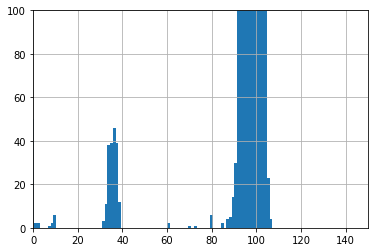

In [292]:
# some of the temp readings are miscoded, eg a small fraction of those labeled
#  farenheit (itemid 223761) look like they're recorded in celsius). 

vitals.valuenum[vitals.itemid.isin([223761])].hist(bins = 1000)
plt.xlim(0,150)
plt.ylim(0,100)

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


(0, 100)

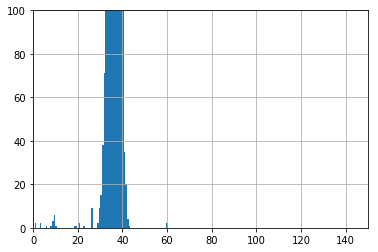

In [293]:
#To account for above, we'll use a threshold of 60 degrees as meaning temp measured in Farenheit, 
#  and convert all temps over that to celsius 

vitals['valuenum'].loc[(vitals['itemid'].isin([223761,678,223761])) &
                      (vitals['valuenum']>60)] = (vitals.valuenum-32)/1.8

#Recheck:  Now all our temp values appear to be in roughly physiologic celsius range
vitals.valuenum[vitals.itemid.isin([223761,678,223761])].hist(bins = 1000)
plt.xlim(0,150)
plt.ylim(0,100)

In [294]:
#Limit to vitals of interest - results in dropping measurements of MAP as these are
# redundant to SBP and DBP (itemid's 456, 6702, 443, 52, 220052, 220181, 225312 )

vitals = vitals[vitals['itemid'].isin([211, 220045,1,442,455,6701,220179,220050,
                            368,8440,8441,8555,220180,220051,
                            618,615,220210,224690,
                            646,220277,
                            807,811,1529,3745,3744,225664,220621,226537,
                            223762,676,223761,678])]

#standardize vital label names for similar measurements w dif itemid's

vitals['label'].loc[vitals['itemid'].isin([211, 220045])] = 'HR'
vitals['label'].loc[vitals['itemid'].isin([51,442,455,6701,220179,220050])] = 'SBP'
vitals['label'].loc[vitals['itemid'].isin([8368,8440,8441,8555,220180,220051])] = 'DBP'
vitals['label'].loc[vitals['itemid'].isin([618,615,220210,224690])] = 'RR'
vitals['label'].loc[vitals['itemid'].isin([646,220277])] = 'SpO2'
vitals['label'].loc[vitals['itemid'].isin([807,811,1529,3745,3744,225664,220621,226537])] = 'Glu'
vitals['label'].loc[vitals['itemid'].isin([223762,676,223761,678])] = 'Temp'

#and add a column for absolute value of ce_minutelag, to allow time frames to by symmetric
# about time of ICU admission

vitals.loc[:,'abso_VSminutelag'] = vitals['ce_minutelag'].abs()

vitals.head()

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,subject_id,icustay_id,hadm_id,charttime,admittime,itemid,valuenum,label,ce_minutelag,abso_VSminutelag
0,22297,251197,142483,2123-11-29 17:00:00,2123-11-27 11:21:00,455,141.0,SBP,801,801
1,24361,250759,187730,2122-05-04 23:00:00,2122-05-04 00:45:00,8441,44.0,DBP,256,256
2,11861,225706,170341,2128-07-05 08:00:00,2128-07-04 11:05:00,807,154.0,Glu,1254,1254
5,19983,210346,197311,2142-03-14 04:45:00,2142-03-08 14:00:00,8441,37.0,DBP,1364,1364
6,12089,217488,185999,2178-05-28 08:15:00,2178-05-27 20:15:00,455,92.0,SBP,272,272


In [295]:
#drop absurd values (eg SpO2 >100, SBP >400, DBP >300, RR >70, Glu >1000, Temp<25C or >50C)
vitals.drop(vitals[((vitals['label']=='SpO2') & (vitals['valuenum']>100)) |
                   ((vitals['label']=='SBP') & (vitals['valuenum'] >400)) |
                   ((vitals['label']=='DBP') & (vitals['valuenum'] >300)) |
                   ((vitals['label']=='RR') & (vitals['valuenum'] >70)) |
                   ((vitals['label']=='Glu') & (vitals['valuenum'] >1000)) |
                   ((vitals['label']=='Temp') & (vitals['valuenum']>50)) |
                   ((vitals['label']=='Temp') & (vitals['valuenum']<25))].index,inplace=True)

vitals.head()

,subject_id,icustay_id,hadm_id,charttime,admittime,itemid,valuenum,label,ce_minutelag,abso_VSminutelag
0,22297,251197,142483,2123-11-29 17:00:00,2123-11-27 11:21:00,455,141.0,SBP,801,801
1,24361,250759,187730,2122-05-04 23:00:00,2122-05-04 00:45:00,8441,44.0,DBP,256,256
2,11861,225706,170341,2128-07-05 08:00:00,2128-07-04 11:05:00,807,154.0,Glu,1254,1254
5,19983,210346,197311,2142-03-14 04:45:00,2142-03-08 14:00:00,8441,37.0,DBP,1364,1364
6,12089,217488,185999,2178-05-28 08:15:00,2178-05-27 20:15:00,455,92.0,SBP,272,272


In [296]:
#limit to pts within our cohort of interest 
vitals_cohort = vitals[vitals.subject_id.isin(NonCrCohort.subject_id)]   

In [297]:
#create seaparate time frame dfs becasue summary stats will be different 
#  depending on time frame

vitals_cohort24h = vitals_cohort[vitals_cohort.abso_VSminutelag < 1440]
vitals_cohort6h = vitals_cohort[vitals_cohort.abso_VSminutelag < 360]
vitals_cohort4h = vitals_cohort[vitals_cohort.abso_VSminutelag < 240]
vitals_cohort2h = vitals_cohort[vitals_cohort.abso_VSminutelag < 120]

vitals_cohort2h.shape


(703891, 10)

In [298]:
#Create the summary statistics for min, max, std deviation for each time frame 
#  starting w 24 hr

#min
min_vitals_cohort24h = vitals_cohort24h.groupby(['icustay_id', 'label']
                                         )['valuenum'].min().reset_index()
min_vitals24h = pd.pivot_table(min_vitals_cohort24h, index='icustay_id', columns = 'label', values = 'valuenum')
min_vitals24h.columns = min_vitals24h.columns + '_min'

#max 24h
max_vitals_cohort24h = vitals_cohort24h.groupby(['icustay_id', 'label']
                                         )['valuenum'].max().reset_index()
max_vitals24h = pd.pivot_table(max_vitals_cohort24h, index='icustay_id', columns = 'label', values = 'valuenum')
max_vitals24h.columns = max_vitals24h.columns + '_max'

#mean 24h
mean_vitals_cohort24h = vitals_cohort24h.groupby(['icustay_id', 'label']
                                         )['valuenum'].mean().reset_index()
mean_vitals24h = pd.pivot_table(mean_vitals_cohort24h, index='icustay_id', columns = 'label', values = 'valuenum')
mean_vitals24h.columns = mean_vitals24h.columns + '_mean'

#sd 24h
sd_vitals_cohort24h = vitals_cohort24h.groupby(['icustay_id', 'label']
                                         )['valuenum'].std().reset_index()
sd_vitals24h = pd.pivot_table(sd_vitals_cohort24h, index='icustay_id', columns = 'label', values = 'valuenum')
sd_vitals24h.columns = sd_vitals24h.columns + '_sd'

#merge into one summary table - aggregate summary vitals for 24h 

agg_vitals24h=pd.merge(pd.merge(pd.merge(max_vitals24h, min_vitals24h,
                    on = 'icustay_id', how = 'inner'),
                    mean_vitals24h, on='icustay_id', how='inner'),
                    sd_vitals24h, on='icustay_id', how = 'inner')

agg_vitals24h.head()

,DBP_max,Glu_max,HR_max,RR_max,SBP_max,SpO2_max,Temp_max,DBP_min,Glu_min,HR_min,...,SBP_mean,SpO2_mean,Temp_mean,DBP_sd,Glu_sd,HR_sd,RR_sd,SBP_sd,SpO2_sd,Temp_sd
icustay_id,,,,,,,,,,,,,,,,,,,,,
200001,68.0,118.0,134.0,32.0,118.0,100.0,37.666667,49.0,72.0,88.0,...,103.423077,98.076923,37.175926,5.214919,23.459184,10.942648,4.777511,8.700221,2.279001,0.508467
200006,87.0,95.0,84.0,27.0,118.0,100.0,37.666668,45.0,71.0,62.0,...,107.636364,98.541667,36.966667,10.777964,10.453981,5.036017,3.202801,8.381075,1.587428,0.621876
200007,94.0,276.0,104.0,29.0,144.0,97.0,37.611109,32.0,98.0,80.0,...,115.000000,95.750000,37.188889,13.218554,59.482490,6.016286,3.618471,14.727148,1.164965,0.500924
200010,122.0,253.0,115.0,23.0,180.0,100.0,37.611111,62.0,127.0,82.0,...,130.000000,99.090909,36.700000,13.364666,65.329932,11.071275,4.884840,16.946976,0.750180,0.580815
200011,75.0,108.0,80.0,34.0,176.0,100.0,37.277778,37.0,94.0,59.0,...,151.000000,95.440000,36.952381,8.502499,7.000000,5.377422,4.460734,14.196671,3.014963,0.238800


In [299]:
#Now 6 hrs

#min
min_vitals_cohort6h = vitals_cohort6h.groupby(['icustay_id', 'label']
                                         )['valuenum'].min().reset_index()
min_vitals6h = pd.pivot_table(min_vitals_cohort6h, index='icustay_id', columns = 'label', values = 'valuenum')
min_vitals6h.columns = min_vitals6h.columns + '_min'

#max
max_vitals_cohort6h = vitals_cohort6h.groupby(['icustay_id', 'label']
                                         )['valuenum'].max().reset_index()
max_vitals6h = pd.pivot_table(max_vitals_cohort6h, index='icustay_id', columns = 'label', values = 'valuenum')
max_vitals6h.columns = max_vitals6h.columns + '_max'

#mean
mean_vitals_cohort6h = vitals_cohort6h.groupby(['icustay_id', 'label']
                                         )['valuenum'].mean().reset_index()
mean_vitals6h = pd.pivot_table(mean_vitals_cohort6h, index='icustay_id', columns = 'label', values = 'valuenum')
mean_vitals6h.columns = mean_vitals6h.columns + '_mean'

#sd
sd_vitals_cohort6h = vitals_cohort6h.groupby(['icustay_id', 'label']
                                         )['valuenum'].std().reset_index()
sd_vitals6h = pd.pivot_table(sd_vitals_cohort6h, index='icustay_id', columns = 'label', values = 'valuenum')
sd_vitals6h.columns = sd_vitals6h.columns + '_sd'

#merge into one summary table - aggregate summary vitals for 6h 

agg_vitals6h=pd.merge(pd.merge(pd.merge(max_vitals6h, min_vitals6h,
                    on = 'icustay_id', how = 'inner'),
                    mean_vitals6h, on='icustay_id', how='inner'),
                    sd_vitals6h, on='icustay_id', how = 'inner')

agg_vitals6h.head()

,DBP_max,Glu_max,HR_max,RR_max,SBP_max,SpO2_max,Temp_max,DBP_min,Glu_min,HR_min,...,SBP_mean,SpO2_mean,Temp_mean,DBP_sd,Glu_sd,HR_sd,RR_sd,SBP_sd,SpO2_sd,Temp_sd
icustay_id,,,,,,,,,,,,,,,,,,,,,
200001,68.0,118.0,115.0,28.0,116.0,100.0,37.666667,58.0,118.0,102.0,...,109.000000,96.500000,37.472222,3.716117,NaN,4.682795,3.852179,5.416026,2.138090,0.274986
200006,87.0,95.0,84.0,27.0,118.0,100.0,36.166666,50.0,93.0,73.0,...,109.333333,99.000000,36.166666,16.574076,1.154701,3.614784,4.307386,9.458682,1.825742,NaN
200007,73.0,276.0,104.0,19.0,130.0,97.0,37.111113,60.0,276.0,83.0,...,122.000000,96.000000,36.750001,4.956477,NaN,7.968689,2.562551,4.289522,1.224745,0.510689
200010,102.0,149.0,115.0,22.0,157.0,100.0,36.666667,78.0,127.0,86.0,...,136.833333,99.000000,36.361111,10.000000,15.556349,13.133019,5.593363,13.242608,0.577350,0.432121
200011,62.0,108.0,77.0,31.0,144.0,100.0,36.833333,37.0,108.0,60.0,...,135.142857,98.285714,36.777778,8.596788,NaN,5.912054,5.118051,6.866066,2.429972,0.078567


In [300]:
#Now 4 hrs

#min
min_vitals_cohort4h = vitals_cohort4h.groupby(['icustay_id', 'label']
                                         )['valuenum'].min().reset_index()
min_vitals4h = pd.pivot_table(min_vitals_cohort4h, index='icustay_id', columns = 'label', values = 'valuenum')
min_vitals4h.columns = min_vitals4h.columns + '_min'

#max
max_vitals_cohort4h = vitals_cohort4h.groupby(['icustay_id', 'label']
                                         )['valuenum'].max().reset_index()
max_vitals4h = pd.pivot_table(max_vitals_cohort4h, index='icustay_id', columns = 'label', values = 'valuenum')
max_vitals4h.columns = max_vitals4h.columns + '_max'

#mean
mean_vitals_cohort4h = vitals_cohort4h.groupby(['icustay_id', 'label']
                                         )['valuenum'].mean().reset_index()
mean_vitals4h = pd.pivot_table(mean_vitals_cohort4h, index='icustay_id', columns = 'label', values = 'valuenum')
mean_vitals4h.columns = mean_vitals4h.columns + '_mean'

#sd
sd_vitals_cohort4h = vitals_cohort4h.groupby(['icustay_id', 'label']
                                         )['valuenum'].std().reset_index()
sd_vitals4h = pd.pivot_table(sd_vitals_cohort4h, index='icustay_id', columns = 'label', values = 'valuenum')
sd_vitals4h.columns = sd_vitals4h.columns + '_sd'

#merge into one summary table - aggregate summary vitals for 4h 

agg_vitals4h=pd.merge(pd.merge(pd.merge(max_vitals4h, min_vitals4h,
                    on = 'icustay_id', how = 'inner'),
                    mean_vitals4h, on='icustay_id', how='inner'),
                    sd_vitals4h, on='icustay_id', how = 'inner')

agg_vitals4h.head()

,DBP_max,Glu_max,HR_max,RR_max,SBP_max,SpO2_max,Temp_max,DBP_min,Glu_min,HR_min,...,SBP_mean,SpO2_mean,Temp_mean,DBP_sd,Glu_sd,HR_sd,RR_sd,SBP_sd,SpO2_sd,Temp_sd
icustay_id,,,,,,,,,,,,,,,,,,,,,
200001,68.0,118.0,115.0,27.0,116.0,98.0,37.666667,61.0,118.0,102.0,...,110.80,96.333333,37.472222,2.880972,NaN,4.844241,3.502380,5.357238,1.632993,0.274986
200006,87.0,93.0,84.0,26.0,118.0,100.0,36.166666,53.0,93.0,73.0,...,111.75,99.750000,36.166666,17.056279,0.0,4.500000,4.381780,8.098354,0.500000,NaN
200007,71.0,276.0,90.0,19.0,130.0,97.0,36.388889,60.0,276.0,83.0,...,122.00,96.000000,36.388889,5.066228,NaN,3.109126,3.000000,5.477226,1.414214,NaN
200010,96.0,149.0,115.0,22.0,157.0,100.0,36.666667,78.0,149.0,86.0,...,137.25,99.000000,36.666667,9.831921,NaN,11.562872,5.856620,16.760569,0.707107,NaN
200011,62.0,108.0,77.0,31.0,140.0,100.0,36.833333,37.0,108.0,60.0,...,135.80,99.600000,36.777778,10.256705,NaN,6.906519,5.520524,3.701351,0.894427,0.078567


In [301]:
#Now 2 h

#min
min_vitals_cohort2h = vitals_cohort2h.groupby(['icustay_id', 'label']
                                         )['valuenum'].min().reset_index()
min_vitals2h = pd.pivot_table(min_vitals_cohort2h, index='icustay_id', columns = 'label', values = 'valuenum')
min_vitals2h.columns = min_vitals2h.columns + '_min'

#max
max_vitals_cohort2h = vitals_cohort2h.groupby(['icustay_id', 'label']
                                         )['valuenum'].max().reset_index()
max_vitals2h = pd.pivot_table(max_vitals_cohort2h, index='icustay_id', columns = 'label', values = 'valuenum')
max_vitals2h.columns = max_vitals2h.columns + '_max'

#mean
mean_vitals_cohort2h = vitals_cohort2h.groupby(['icustay_id', 'label']
                                         )['valuenum'].mean().reset_index()
mean_vitals2h = pd.pivot_table(mean_vitals_cohort2h, index='icustay_id', columns = 'label', values = 'valuenum')
mean_vitals2h.columns = mean_vitals2h.columns + '_mean'

#sd
sd_vitals_cohort2h = vitals_cohort2h.groupby(['icustay_id', 'label']
                                         )['valuenum'].std().reset_index()
sd_vitals2h = pd.pivot_table(sd_vitals_cohort2h, index='icustay_id', columns = 'label', values = 'valuenum')
sd_vitals2h.columns = sd_vitals2h.columns + '_sd'

#merge into one summary table - aggregate summary vitals for 2h 

agg_vitals2h=pd.merge(pd.merge(pd.merge(max_vitals2h, min_vitals2h,
                    on = 'icustay_id', how = 'inner'),
                    mean_vitals2h, on='icustay_id', how='inner'),
                    sd_vitals2h, on='icustay_id', how = 'inner')

agg_vitals2h.head()



,DBP_max,Glu_max,HR_max,RR_max,SBP_max,SpO2_max,Temp_max,DBP_min,Glu_min,HR_min,...,SBP_mean,SpO2_mean,Temp_mean,DBP_sd,Glu_sd,HR_sd,RR_sd,SBP_sd,SpO2_sd,Temp_sd
icustay_id,,,,,,,,,,,,,,,,,,,,,
200001,68.0,NaN,115.0,26.0,113.0,98.0,37.277778,65.0,NaN,108.0,...,112.0,96.000000,37.277778,1.732051,NaN,3.109126,3.415650,1.732051,1.825742,NaN
200006,87.0,93.0,84.0,26.0,118.0,100.0,36.166666,87.0,93.0,78.0,...,118.0,100.000000,36.166666,0.000000,0.0,4.242641,4.163332,0.000000,0.000000,NaN
200007,71.0,276.0,90.0,19.0,130.0,97.0,36.388889,70.0,276.0,84.0,...,125.5,96.500000,36.388889,0.707107,NaN,4.242641,4.242641,6.363961,0.707107,NaN
200010,96.0,149.0,115.0,22.0,138.0,100.0,36.666667,78.0,149.0,109.0,...,138.0,99.000000,36.666667,12.727922,NaN,3.464102,4.509250,0.000000,1.000000,NaN
200011,62.0,108.0,77.0,31.0,138.0,100.0,36.833333,45.0,108.0,62.0,...,136.0,99.333333,36.833333,9.073772,NaN,7.549834,6.055301,2.645751,1.154701,NaN


In [302]:
#merge the aggregated vitals with the rest of the masterfile, for each time frame 

Masterfile24h_NonCr = pd.merge(Masterfile24h_NonCr, agg_vitals24h,
                             on='icustay_id', how='inner')
Masterfile6h_NonCr = pd.merge(Masterfile6h_NonCr, agg_vitals6h,
                             on='icustay_id', how='inner')
Masterfile4h_NonCr = pd.merge(Masterfile4h_NonCr, agg_vitals4h,
                             on='icustay_id', how='inner')
Masterfile2h_NonCr = pd.merge(Masterfile2h_NonCr, agg_vitals2h,
                             on='icustay_id', how='inner')

Masterfile2h_NonCr.head()

,subject_id,icustay_id,hadm_id,Cr_initial_time,admittime,Cr_itemid,Cr_value_initial,LabName,icu_intime,labs_icuminutelag,...,SBP_mean,SpO2_mean,Temp_mean,DBP_sd,Glu_sd,HR_sd,RR_sd,SBP_sd,SpO2_sd,Temp_sd
0,9,220597,150750,2149-11-09 11:20:00,2149-11-09 13:06:00,50912,1.2,Creatinine,2149-11-09 13:07:02,-107,...,NaN,98.666667,35.277778,NaN,NaN,1.810463,0.632456,NaN,1.118034,0.314271
1,11,229441,194540,2178-04-16 07:12:00,2178-04-16 06:18:00,50912,0.7,Creatinine,2178-04-16 06:19:32,53,...,110.500000,96.500000,37.055556,7.118052,0.000000,4.272002,1.825742,3.696846,0.707107,0.235702
2,13,263738,143045,2167-01-08 20:28:00,2167-01-08 18:43:00,50912,0.6,Creatinine,2167-01-08 18:44:25,104,...,NaN,98.000000,37.277777,NaN,11.547005,2.121320,2.828427,NaN,0.000000,NaN
3,18,298129,188822,2167-10-02 10:36:00,2167-10-02 11:18:00,50912,0.9,Creatinine,2167-10-02 11:20:39,-44,...,151.400000,99.500000,37.666668,5.449771,7.758866,9.949874,2.828427,10.382678,0.577350,NaN
4,24,262236,161859,2139-06-06 17:54:00,2139-06-06 16:14:00,50912,0.9,Creatinine,2139-06-06 16:15:36,99,...,125.833333,98.500000,36.166666,3.430258,0.000000,4.665476,1.505545,4.875107,1.224745,NaN


In [303]:
# check columns -- all the max/min/mean/sd should be there (and only once each!)
Masterfile2h_NonCr.columns

Index(['subject_id', 'icustay_id', 'hadm_id', 'Cr_initial_time', 'admittime',
       'Cr_itemid', 'Cr_value_initial', 'LabName', 'icu_intime',
       'labs_icuminutelag', 'labs_minutelag', 'abso_icuminutelag', 'gender',
       'hospital_expire_flag', 'ageatadmin', 'hosp_LOS_d', 'icustay_id_order',
       'icu_length_of_stay', 'deathtime', 'admission_type',
       'admission_location', 'ethnicity', 'diagnosis', 'service',
       'RenalFailure_dx', 'Sepsis_dx', 'Infec_dx', 'Albumin', 'Bicarbonate',
       'Bilirubin, Total', 'Calcium, Total', 'Chloride', 'Ferritin', 'Folate',
       'Hematocrit', 'Hemoglobin', 'INR(PT)', 'Iron',
       'Iron Binding Capacity, Total', 'Lactate', 'Lactate Dehydrogenase (LD)',
       'MCH', 'MCHC', 'MCV', 'Magnesium', 'PT', 'PTT', 'Phosphate',
       'Platelet Count', 'Potassium', 'Protein, Total', 'Red Blood Cells',
       'Sodium', 'Transferrin', 'Urea Nitrogen', 'Vitamin B12', 'WBC Count',
       'White Blood Cells', 'pCO2', 'pH', 'pO2', 'DBP_max', 'Glu_

In [ ]:
# Pull the data regarding use of vasopressors. ItemIDs corresponding to vasopressors were 
#    identified by finding words/partial words corresponding to: milrinone (Primacor), 
#    phenylephrine (Neosynephrine), epinephrine, norepinephrine (Levophed), vasopressin, 
#    dobutamine, dopamine
# ce_minutelag will be the time from ICU admission to starting vasopressor infusion 

#  mv corresponds to a later era of medical record than cv, which is done in next query

# MAY SWITCH CELL TO TEXT to avoid re-running query 

vasopressorsMV = run_query(''' SELECT  icu.subject_id, icu.icustay_id, icu.intime, mv.itemid, 
        mv.starttime, mv.endtime, mv.amount, mv.amountuom, mv.rate,
        it.label,
    DATETIME_DIFF(mv.starttime, icu.intime, MINUTE) AS ce_minutelag
    FROM `physionet-data.mimiciii_clinical.inputevents_mv` mv
    INNER JOIN `physionet-data.mimiciii_clinical.icustays` icu
    ON mv.icustay_id = icu.icustay_id
    INNER JOIN `physionet-data.mimiciii_clinical.d_items` it
    ON mv.itemid = it.itemid
    WHERE mv.itemid in (1136,   5461,   1222,   1327,   4501,   3112,   5656,   5682,
         5747,   5752,   5805,   5329,   2248,   2334,   2445,   2561,
         2765,   6090,   6255,   6395,   7341,   6512,   6690,   6752,
        30119,  30125,  30127,  30043,  30306,  30307,  30309,  30042,
        30044,  30047,  30051,  30120,  30128,  42273,  42802, 221289,
       221653, 221662, 221749, 221906, 221986, 222315)
    ''' )

vasopressorsMV


In [ ]:
# Pull the data regarding use of vasopressors 
#  ce_minutelag will be the time from ICU admission to starting vasopressor infusion 
#  CV corresponds to earlier era of medical record than mv, so this will be new set of pts

# MAY SWITC CELL TO TEXT to avoid re-running query 

vasopressorsCV = run_query(''' SELECT  icu.subject_id, icu.icustay_id, icu.intime, cv.itemid, 
        cv.charttime, cv.amount, cv.amountuom, cv.rate,
        it.label,
    DATETIME_DIFF(cv.charttime, icu.intime, MINUTE) AS ce_minutelag
    FROM `physionet-data.mimiciii_clinical.inputevents_cv` cv
    INNER JOIN `physionet-data.mimiciii_clinical.icustays` icu
    ON cv.icustay_id = icu.icustay_id
    INNER JOIN `physionet-data.mimiciii_clinical.d_items` it
    ON cv.itemid = it.itemid
    WHERE cv.itemid in (1136,   5461,   1222,   1327,   4501,   3112,   5656,   5682,
         5747,   5752,   5805,   5329,   2248,   2334,   2445,   2561,
         2765,   6090,   6255,   6395,   7341,   6512,   6690,   6752,
        30119,  30125,  30127,  30043,  30306,  30307,  30309,  30042,
        30044,  30047,  30051,  30120,  30128,  42273,  42802, 221289,
       221653, 221662, 221749, 221906, 221986, 222315)
    ''' )

vasopressorsCV

In [304]:
#save to avoid re-running queries (then switch cell to text)

vasopressorsMV.to_csv(index=False, path_or_buf='vasopressorsMV.csv')

vasopressorsCV.to_csv(index=False, path_or_buf='vasopressorsCV.csv')


In [305]:
#read in the vasopressor files

vasopressorsMV = pd.read_csv('vasopressorsMV.csv')

vasopressorsCV = pd.read_csv('vasopressorsCV.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [306]:
#combine the vasopressorsMV and CV to make full vasopressors dataframe
#  (MV and CV correspond to different era of medial records at BIDMC)

vasopressors = pd.concat([vasopressorsMV, vasopressorsCV], axis=0)
vasopressors

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  after removing the cwd from sys.path.


,amount,amountuom,ce_minutelag,charttime,endtime,icustay_id,intime,itemid,label,rate,starttime,subject_id
0,0.024228,mg,3488,NaN,2143-07-24 23:25:00,298878,2143-07-22 13:07:55,221906,Norepinephrine,0.025003,2143-07-24 23:15:00,27455
1,0.022288,mg,906,NaN,2113-09-26 00:31:00,267876,2113-09-25 09:24:26,221749,Phenylephrine,0.297969,2113-09-26 00:30:00,71716
2,0.843589,mg,1396,NaN,2137-02-08 12:15:00,262081,2137-02-07 12:16:48,221749,Phenylephrine,0.247394,2137-02-08 11:32:00,78365
3,10.345117,mg,289,NaN,2144-04-21 17:13:00,257662,2144-04-21 08:56:17,221749,Phenylephrine,0.753578,2144-04-21 13:45:00,95000
4,1.719609,mg,666,NaN,2113-09-25 21:03:00,267876,2113-09-25 09:24:26,221749,Phenylephrine,0.696649,2113-09-25 20:30:00,71716
5,0.665168,mg,28960,NaN,2108-11-27 14:10:00,279751,2108-11-07 11:00:27,221749,Phenylephrine,0.300031,2108-11-27 13:40:00,83272
6,8.130999,mg,29272,NaN,2108-11-27 21:09:00,279751,2108-11-07 11:00:27,221749,Phenylephrine,0.803117,2108-11-27 18:52:00,83272
7,6.810769,mg,29714,NaN,2108-11-28 07:10:00,279751,2108-11-07 11:00:27,221749,Phenylephrine,0.311358,2108-11-28 02:14:00,83272
8,5.350391,mg,1270,NaN,2113-09-26 08:34:00,267876,2113-09-25 09:24:26,221749,Phenylephrine,0.596077,2113-09-26 06:34:00,71716
9,11.980750,mg,29602,NaN,2108-11-28 03:44:00,279751,2108-11-07 11:00:27,221749,Phenylephrine,0.802580,2108-11-28 00:22:00,83272


In [309]:
vasopressors_cohort = vasopressors[vasopressors.icustay_id.isin(NonCrCohort.icustay_id)]

vasopressors_cohort.shape
#Results in 903 unique patients 

(1040088, 12)

In [310]:
#check for negative time lags

vasopressors_cohort[vasopressors_cohort.ce_minutelag < 0].shape

#There are 307 (about 1/3 of cohort with neg time lags, so take absolute value)

vasopressors_cohort.loc[:,'abso_ceminutelag']=vasopressors_cohort.ce_minutelag.abs()
vasopressors_cohort.head(3)


/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,amount,amountuom,ce_minutelag,charttime,endtime,icustay_id,intime,itemid,label,rate,starttime,subject_id,abso_ceminutelag
0,0.024228,mg,3488,NaN,2143-07-24 23:25:00,298878,2143-07-22 13:07:55,221906,Norepinephrine,0.025003,2143-07-24 23:15:00,27455,3488
2,0.843589,mg,1396,NaN,2137-02-08 12:15:00,262081,2137-02-07 12:16:48,221749,Phenylephrine,0.247394,2137-02-08 11:32:00,78365,1396
3,10.345117,mg,289,NaN,2144-04-21 17:13:00,257662,2144-04-21 08:56:17,221749,Phenylephrine,0.753578,2144-04-21 13:45:00,95000,289


In [311]:
#keep only minimum time lag to start of pressors for each patient
vasopressors_early=vasopressors_cohort.loc[vasopressors_cohort.groupby([
    'subject_id','icustay_id'])['abso_ceminutelag'].idxmin()]

vasopressors_early.head(3)

,amount,amountuom,ce_minutelag,charttime,endtime,icustay_id,intime,itemid,label,rate,starttime,subject_id,abso_ceminutelag
316225,NaN,NaN,5903,2149-11-13 15:30:00,NaN,220597,2149-11-09 13:07:02,30120,Levophed-k,0.22,NaN,9,5903
1712044,NaN,NaN,1321,2167-01-09 16:45:00,NaN,263738,2167-01-08 18:44:25,30128,Neosynephrine-k,0.30,NaN,13,1321
622705,0.0,mg,164,2160-11-02 06:00:00,NaN,203487,2160-11-02 03:16:23,30043,Dopamine,NaN,NaN,25,164


In [312]:
#create df's of pts for whom the pressor start time is within the time frames of interest 

pressor_use24h = vasopressors_early[vasopressors_early.abso_ceminutelag < 1440]
pressor_use6h = vasopressors_early[vasopressors_early.abso_ceminutelag < 360]
pressor_use4h = vasopressors_early[vasopressors_early.abso_ceminutelag < 240]
pressor_use2h = vasopressors_early[vasopressors_early.abso_ceminutelag < 120]

pressor_use4h['icustay_id'].unique().size

5384

In [313]:
Masterfile2h_NonCr.columns

Index(['subject_id', 'icustay_id', 'hadm_id', 'Cr_initial_time', 'admittime',
       'Cr_itemid', 'Cr_value_initial', 'LabName', 'icu_intime',
       'labs_icuminutelag', 'labs_minutelag', 'abso_icuminutelag', 'gender',
       'hospital_expire_flag', 'ageatadmin', 'hosp_LOS_d', 'icustay_id_order',
       'icu_length_of_stay', 'deathtime', 'admission_type',
       'admission_location', 'ethnicity', 'diagnosis', 'service',
       'RenalFailure_dx', 'Sepsis_dx', 'Infec_dx', 'Albumin', 'Bicarbonate',
       'Bilirubin, Total', 'Calcium, Total', 'Chloride', 'Ferritin', 'Folate',
       'Hematocrit', 'Hemoglobin', 'INR(PT)', 'Iron',
       'Iron Binding Capacity, Total', 'Lactate', 'Lactate Dehydrogenase (LD)',
       'MCH', 'MCHC', 'MCV', 'Magnesium', 'PT', 'PTT', 'Phosphate',
       'Platelet Count', 'Potassium', 'Protein, Total', 'Red Blood Cells',
       'Sodium', 'Transferrin', 'Urea Nitrogen', 'Vitamin B12', 'WBC Count',
       'White Blood Cells', 'pCO2', 'pH', 'pO2', 'DBP_max', 'Glu_

In [314]:
#Add True/False column to mastefile depending on whether pt is in the pressor_use df for
#  corresponding time frame

Masterfile24h_NonCr.loc[:,'Vasopressor_use']=np.where(
    Masterfile24h_NonCr.icustay_id.isin(pressor_use24h.icustay_id),True,False)

Masterfile6h_NonCr.loc[:,'Vasopressor_use']=np.where(
    Masterfile6h_NonCr.icustay_id.isin(pressor_use6h.icustay_id),True,False)

Masterfile4h_NonCr.loc[:,'Vasopressor_use']=np.where(
    Masterfile4h_NonCr.icustay_id.isin(pressor_use4h.icustay_id),True,False)

Masterfile2h_NonCr.loc[:,'Vasopressor_use']=np.where(
    Masterfile2h_NonCr.icustay_id.isin(pressor_use2h.icustay_id),True,False)


In [315]:
Masterfile2h_NonCr.head(3)

,subject_id,icustay_id,hadm_id,Cr_initial_time,admittime,Cr_itemid,Cr_value_initial,LabName,icu_intime,labs_icuminutelag,...,SpO2_mean,Temp_mean,DBP_sd,Glu_sd,HR_sd,RR_sd,SBP_sd,SpO2_sd,Temp_sd,Vasopressor_use
0,9,220597,150750,2149-11-09 11:20:00,2149-11-09 13:06:00,50912,1.2,Creatinine,2149-11-09 13:07:02,-107,...,98.666667,35.277778,NaN,NaN,1.810463,0.632456,NaN,1.118034,0.314271,False
1,11,229441,194540,2178-04-16 07:12:00,2178-04-16 06:18:00,50912,0.7,Creatinine,2178-04-16 06:19:32,53,...,96.500000,37.055556,7.118052,0.000000,4.272002,1.825742,3.696846,0.707107,0.235702,False
2,13,263738,143045,2167-01-08 20:28:00,2167-01-08 18:43:00,50912,0.6,Creatinine,2167-01-08 18:44:25,104,...,98.000000,37.277777,NaN,11.547005,2.121320,2.828427,NaN,0.000000,NaN,False


In [316]:
#save completed masterfiles

Masterfile24h_NonCr.to_csv(index=False, path_or_buf='masterfile24h_NonCr.csv')

Masterfile6h_NonCr.to_csv(index=False, path_or_buf='masterfile6h_NonCr.csv')

Masterfile4h_NonCr.to_csv(index=False, path_or_buf='masterfile4h_NonCr.csv')

Masterfile2h_NonCr.to_csv(index=False, path_or_buf='masterfile2h_NonCr.csv')


## Compare the NonCr cohort pts to the Cr cohort pts

In [317]:
#Read in the 2 hr files 

Masterfile2h_Cr = pd.read_csv('masterfile2h_Cr.csv')

Masterfile2h_NonCr = pd.read_csv('masterfile2h_NonCr.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [318]:
Masterfile2h_Cr.columns

Index(['subject_id', 'icustay_id', 'Cr_baseline_time', 'admittime',
       'Cr_itemid', 'Cr_value_baseline', 'LabName', 'Cr_base_timelag',
       'hadm_id', 'gender', 'hospital_expire_flag_x', 'ageatadmin',
       'hosp_LOS_d_x', 'icustay_id_order', 'icu_length_of_stay', 'deathtime',
       'admission_type', 'admission_location', 'ethnicity', 'diagnosis',
       'service', 'RenalFailure_dx', 'Sepsis_dx', 'Infec_dx',
       'Cr_initial_time', 'Cr_value_initial', 'icu_intime',
       'labs_icuminutelag', 'labs_minutelag', 'abso_icuminutelag',
       'hospital_expire_flag_y', 'hosp_LOS_d_y', 'Albumin', 'Bicarbonate',
       'Bilirubin, Total', 'Calcium, Total', 'Chloride', 'Ferritin', 'Folate',
       'Hematocrit', 'Hemoglobin', 'INR(PT)', 'Iron',
       'Iron Binding Capacity, Total', 'Lactate', 'Lactate Dehydrogenase (LD)',
       'MCH', 'MCHC', 'MCV', 'Magnesium', 'PT', 'PTT', 'Phosphate',
       'Platelet Count', 'Potassium', 'Protein, Total', 'Red Blood Cells',
       'Sodium', 'Tran

In [319]:
Masterfile2h_NonCr.subject_id.unique().size

13853

In [341]:
#Generate numbers for the cohort description table
#CR WITH BASELINE COHORT
print('WITH BASELINE cohort')
print('')

print('Hgb Value Initial')
print(Masterfile2h_Cr.Hemoglobin.describe())
print('')

print('Cr Value Initial')
print(Masterfile2h_Cr.Cr_value_initial.describe())
print(Masterfile2h_Cr.Cr_value_initial.median())
print('')

print('Cr Value Baseline')
print(Masterfile2h_Cr.Cr_value_baseline.describe())
print('')

print('Age At Admission')
print(Masterfile2h_Cr.ageatadmin.describe())
print('')

print('ICU LOS hrs')
print(Masterfile2h_Cr.icu_length_of_stay.describe())
print('') 

print('Hospital LOS')
print(Masterfile2h_Cr.hosp_LOS_d_x.describe())
print('')

print('Hospital Mortality')
print(Masterfile2h_Cr.hospital_expire_flag_x.value_counts())
print(Masterfile2h_Cr.hospital_expire_flag_x.value_counts(normalize=True)*100)
print('')

print('Time Lag (days) from baseline draw to admiit')
Cr30day=Masterfile2h_Cr[Masterfile2h_Cr.Cr_base_timelag<=30]
print(Cr30day.Cr_base_timelag.describe())
print('')

print('%Gender')
print(Masterfile2h_Cr.gender.value_counts())
print(Masterfile2h_Cr.gender.value_counts(normalize=True)*100)
print('')

print('%Vasopressors')
print(Masterfile2h_Cr.Vasopressor_use.value_counts())
print(Masterfile2h_Cr.Vasopressor_use.value_counts(normalize=True)*100)
print('')

print('%Admission Type')
print(Masterfile2h_Cr.admission_type.value_counts())
print(Masterfile2h_Cr.admission_type.value_counts(normalize=True)*100)
print('')

#print('Admission dx Bleeding')
#print(Masterfile2h_NonCr._________dx.describe())
#print('')

print('%Admission dx Sepsis')
print(Masterfile2h_Cr.Sepsis_dx.value_counts())
print(Masterfile2h_Cr.Sepsis_dx.value_counts(normalize=True)*100)
print('')

print('%Admission dx Infec')
print(Masterfile2h_Cr.Infec_dx.value_counts())
print(Masterfile2h_Cr.Infec_dx.value_counts(normalize=True)*100)
print('')

WITH BASELINE cohort

Hgb Value Initial
count    2404.000000
mean       10.383486
std         1.908431
min         4.700000
25%         9.037500
50%        10.300000
75%        11.500000
max        21.800000
Name: Hemoglobin, dtype: float64

Cr Value Initial
count    2614.000000
mean        1.398355
std         1.589460
min         0.200000
25%         0.700000
50%         0.900000
75%         1.300000
max        21.900000
Name: Cr_value_initial, dtype: float64
0.9

Cr Value Baseline
count    2615.000000
mean        1.288222
std         1.342000
min         0.200000
25%         0.800000
50%         1.000000
75%         1.200000
max        15.400000
Name: Cr_value_baseline, dtype: float64

Age At Admission
count    2615.000000
mean       63.977820
std        14.317457
min        19.000000
25%        55.000000
50%        65.000000
75%        75.000000
max        89.000000
Name: ageatadmin, dtype: float64

ICU LOS hrs
count    2615.000000
mean       91.183174
std       131.833906
min     

In [324]:
OldHgbMasterfile2h.shape

(6281, 84)

In [325]:
OldHgbMasterfile2h.subject_id.unique().size

6281

In [326]:
OldHgbMasterfile2h.columns

Index(['Unnamed: 0', 'subject_id', 'icustay_id', 'Hb_baseline_time',
       'admittime', 'Hb_value_baseline', 'Hem_base_timelag', 'Hb_initial_time',
       'Hb_value_initial', 'hadm_id', 'gender', 'ageatadmin',
       'icu_length_of_stay', 'admission_type', 'admission_location',
       'ethnicity', 'diagnosis', 'current_service', 'Bleed_dx', 'Albumin',
       'Bicarbonate', 'Bilirubin, Total', 'Calcium, Total', 'Chloride',
       'Creatinine', 'Ferritin', 'Folate', 'Hematocrit', 'INR(PT)', 'Iron',
       'Iron Binding Capacity, Total', 'Lactate', 'Lactate Dehydrogenase (LD)',
       'MCH', 'MCHC', 'MCV', 'pCO2', 'pH', 'Phosphate', 'Platelet Count',
       'pO2', 'Potassium', 'Protein, Total', 'PT', 'PTT', 'Red Blood Cells',
       'Sodium', 'Transferrin', 'Urea Nitrogen', 'Vitamin B12',
       'White Blood Cells', 'DBP_max', 'DBP_mean', 'DBP_min', 'DBP_sd',
       'GLU_max', 'GLU_mean', 'GLU_min', 'GLU_sd', 'HR_max', 'HR_mean',
       'HR_min', 'HR_sd', 'MAP_max', 'MAP_mean', 'MAP_min'

In [327]:
FullCohortBoth= pd.concat([OldHgbMasterfile2h,
                          OldCrMasterfile2h],axis=0)
FullCohortBoth.head(3)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  


,Albumin,Bicarbonate,"Bilirubin, Total",Bleed_dx,"Calcium, Total",Chloride,Cr_base_timelag,Cr_baseline_time,Cr_initial_time,Cr_value_baseline,...,ethnicity,gender,hadm_id,icu_length_of_stay,icustay_id,pCO2,pH,pO2,subject_id,vassopresor_doses
0,1.8,13.0,0.8,No,5.8,111.0,NaN,NaN,NaN,NaN,...,WHITE,M,145834,145,211552,40.0,7.35,20.0,3,NaN
1,3.0,15.0,0.2,No,8.6,105.0,NaN,NaN,NaN,NaN,...,WHITE,F,107064,88,228232,44.0,7.39,104.0,6,NaN
2,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,...,WHITE,F,194023,50,277042,35.0,7.43,376.0,17,NaN


In [337]:
#what is the overlap between cohorts
#  after limiting to only pts whose baseline is within 30 days
#  (This makes use of the 2hr mastefiles generated by the R workbooks for Hgb & Cr, here
#   denoted as "OldCrMasterfile2h and OldHgbMaterfile2h")

Cr30d=OldCrMasterfile2h[OldCrMasterfile2h.Cr_base_timelag<=30]
Hgb30d=OldHgbMasterfile2h[OldHgbMasterfile2h.Hem_base_timelag<=30]

Cr30d[Cr30d.subject_id.isin(Hgb30d.subject_id)].shape

(4471, 86)

In [338]:
#Above we have only generated file for patients without outpatient Cr
# Use output of 2hr Hgb masterfile output of R file (here called OldHgbMasterfile2h) and
#  subtract subject IDs in that df to get a df of patients with NO outpatient baseline

    ~Masterfile2h_NonCr.subject_id.isin(OldHgbMasterfile2h.subject_id)]

Masterfile2h_NoBL

,subject_id,icustay_id,hadm_id,Cr_initial_time,admittime,Cr_itemid,Cr_value_initial,LabName,icu_intime,labs_icuminutelag,...,SpO2_mean,Temp_mean,DBP_sd,Glu_sd,HR_sd,RR_sd,SBP_sd,SpO2_sd,Temp_sd,Vasopressor_use
0,9,220597,150750,2149-11-09 11:20:00,2149-11-09 13:06:00,50912,1.2,Creatinine,2149-11-09 13:07:02,-107,...,98.666667,35.277778,NaN,NaN,1.810463,0.632456,NaN,1.118034,0.314271,False
1,11,229441,194540,2178-04-16 07:12:00,2178-04-16 06:18:00,50912,0.7,Creatinine,2178-04-16 06:19:32,53,...,96.500000,37.055556,7.118052,0.000000,4.272002,1.825742,3.696846,0.707107,0.235702,False
2,13,263738,143045,2167-01-08 20:28:00,2167-01-08 18:43:00,50912,0.6,Creatinine,2167-01-08 18:44:25,104,...,98.000000,37.277777,NaN,11.547005,2.121320,2.828427,NaN,0.000000,NaN,False
3,18,298129,188822,2167-10-02 10:36:00,2167-10-02 11:18:00,50912,0.9,Creatinine,2167-10-02 11:20:39,-44,...,99.500000,37.666668,5.449771,7.758866,9.949874,2.828427,10.382678,0.577350,NaN,False
4,24,262236,161859,2139-06-06 17:54:00,2139-06-06 16:14:00,50912,0.9,Creatinine,2139-06-06 16:15:36,99,...,98.500000,36.166666,3.430258,0.000000,4.665476,1.505545,4.875107,1.224745,NaN,False
5,25,203487,129635,2160-11-02 03:59:00,2160-11-02 02:06:00,50912,1.6,Creatinine,2160-11-02 03:16:23,43,...,95.000000,36.722221,5.507571,6.350853,5.744563,4.690416,2.516611,0.816497,NaN,False
6,31,254478,128652,2108-08-22 23:03:00,2108-08-22 23:27:00,50912,0.9,Creatinine,2108-08-22 23:28:42,-25,...,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,False
7,37,213503,188670,2183-08-23 10:33:00,2183-08-21 16:48:00,50912,1.0,Creatinine,2183-08-23 12:01:45,-88,...,97.250000,38.166665,5.802298,0.000000,1.500000,5.123475,6.137318,0.500000,NaN,False
8,38,248910,185910,2166-08-10 00:17:00,2166-08-10 00:28:00,50912,1.8,Creatinine,2166-08-10 00:29:36,-12,...,99.500000,34.611113,5.845226,0.000000,5.125102,2.562551,14.518953,1.000000,NaN,True
9,42,210828,119203,2116-04-26 20:00:00,2116-04-26 18:58:00,50912,0.7,Creatinine,2116-04-26 18:59:35,61,...,97.000000,35.722224,3.511885,0.000000,3.214550,1.414214,0.577350,0.000000,NaN,False


In [339]:
#check number of patients in no-baseline cohort (13,551)

Masterfile2h_NoBL.shape

(13551, 90)

In [344]:
#Generate numbers for the cohort description table
#  NON-BL COHORT

print('WITHOUT ANY BASELINE cohort')
print('')

print('Hgb Value Initial')
print(Masterfile2h_NoBL.Hemoglobin.describe())
print('')

print('Cr Value Initial')
print(Masterfile2h_NoBL.Cr_value_initial.describe())
print(Masterfile2h_NoBL.Cr_value_initial.median())
print('')

#print('Cr Value Baseline')
#print(Masterfile2h_NonCr.Cr_value_baseline.describe()))
#print('')

print('Age At Admission')
print(Masterfile2h_NoBL.ageatadmin.describe())
print('')

print('ICU LOS hrs')
print(Masterfile2h_NoBL.icu_length_of_stay.describe())
print('') 

print('Hospital LOS')
print(Masterfile2h_NoBL.hosp_LOS_d.describe())
print('')

print('Hospital Mortality')
print(Masterfile2h_NoBL.hospital_expire_flag.describe())
print('')

#print('Time Lag (days) from baseline draw to admiit')
#print(Masterfile2h_NonCr.Cr_base_timelag.describe())
#print('')

print('%Gender')
print(Masterfile2h_NoBL.gender.value_counts(normalize=True)*100)
print(Masterfile2h_NoBL.gender.value_counts(normalize=True)*100)
print('')

print('%Vasopressors')
print(Masterfile2h_NoBL.Vasopressor_use.value_counts())
print(Masterfile2h_NoBL.Vasopressor_use.value_counts(normalize=True)*100)
print('')

print('%Admission Type')
print(Masterfile2h_NoBL.admission_type.value_counts())
print(Masterfile2h_NoBL.admission_type.value_counts(normalize=True)*100)
print('')



WITHOUT ANY BASELINE cohort

Hgb Value Initial
count    12616.000000
mean        11.471829
std          2.242283
min          2.800000
25%          9.900000
50%         11.400000
75%         13.000000
max         19.800000
Name: Hemoglobin, dtype: float64

Cr Value Initial
count    13547.000000
mean         1.344940
std          1.507639
min          0.100000
25%          0.700000
50%          0.900000
75%          1.300000
max         43.000000
Name: Cr_value_initial, dtype: float64
0.9

Age At Admission
count    13551.000000
mean        61.175264
std         17.782716
min         15.000000
25%         50.000000
50%         63.000000
75%         76.000000
max         89.000000
Name: ageatadmin, dtype: float64

ICU LOS hrs
count    13551.000000
mean       114.880525
std        163.558123
min          4.000000
25%         32.000000
50%         57.000000
75%        121.000000
max       3695.000000
Name: icu_length_of_stay, dtype: float64

Hospital LOS
count    13551.000000
mean        10

In [370]:
#Generate numbers for the cohort description table
#  HGB with BL Cohort (again using output from R cohort selection file for hgb)

print('HGB WITH BASELINE cohort')
print('')

print('Cr Value Initial')
print(OldHgbMasterfile2h.Creatinine.describe())
print(OldHgbMasterfile2h.Creatinine.median())
print('')

print('Hgb Value Initial')
print(OldHgbMasterfile2h.Hb_value_initial.describe())
print('')

print('Hgb Value Baseline')
print(OldHgbMasterfile2h.Hb_value_baseline.describe())
print('')

print('Age At Admission')
print(OldHgbMasterfile2h.ageatadmin.describe())
print('')

print('ICU LOS hrs')
print(OldHgbMasterfile2h.icu_length_of_stay.describe())
print('') 

#print('Hospital LOS')
#print(OldHgbMasterfile2h.hosp_LOS_d.describe())
#print('')

#print('Hospital Mortality')
#print(OldHgbMasterfile2h.hospital_expire_flag.describe())
#print('')

#print('Time Lag (days) from baseline draw to admiit')
#print(Masterfile2h_NonCr.Cr_base_timelag.describe())
#print('')

print('%Gender')
print(OldHgbMasterfile2h.gender.value_counts(normalize=True)*100)
print(OldHgbMasterfile2h.gender.value_counts(normalize=True)*100)
print('')

print('%Vasopressors')
print(OldHgbMasterfile2h.vassopresor_doses.value_counts())
print(OldHgbMasterfile2h.vassopresor_doses.value_counts(normalize=True)*100)
print('')

print('%Admission Type')
print(OldHgbMasterfile2h.admission_type.value_counts())
print(OldHgbMasterfile2h.admission_type.value_counts(normalize=True)*100)
print('')



HGB WITH BASELINE cohort

Cr Value Initial
count    5067.000000
mean        1.434458
std         1.597360
min         0.100000
25%         0.700000
50%         1.000000
75%         1.400000
max        21.900000
Name: Creatinine, dtype: float64
1.0

Hgb Value Initial
count    6281.000000
mean       11.476055
std         2.154506
min         2.400000
25%        10.000000
50%        11.600000
75%        13.000000
max        21.800000
Name: Hb_value_initial, dtype: float64

Hgb Value Baseline
count    6281.000000
mean       12.250231
std         2.009696
min         4.100000
25%        10.800000
50%        12.300000
75%        13.700000
max        22.000000
Name: Hb_value_baseline, dtype: float64

Age At Admission
count    6281.000000
mean       63.602611
std        14.345210
min        18.000000
25%        54.000000
50%        65.000000
75%        75.000000
max        89.000000
Name: ageatadmin, dtype: float64

ICU LOS hrs
count    6281.000000
mean       86.623308
std       126.520862
min

In [357]:
#summary statistics for time lag for Cr  (lab draw time to admit time)
Masterfile2h_Cr.Cr_base_timelag.describe()

count    2615.000000
mean      -13.705545
std        21.254832
min      -323.000000
25%       -16.000000
50%       -10.000000
75%        -6.000000
max        -4.000000
Name: Cr_base_timelag, dtype: float64

In [361]:
#summary statistics for time lag for Hgb (lab draw time to admit time)
OldHgbMasterfile2h.Hem_base_timelag.describe()

count    6281.000000
mean      -14.321605
std        25.906275
min      -357.000000
25%       -16.000000
50%        -9.000000
75%        -6.000000
max        -4.000000
Name: Hem_base_timelag, dtype: float64